# Problem 2: Numerical Bifurcation Analysis with One-Term Kantorovich Method

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

### Step 1: Finite Difference Discretization

We discretize $x \in [0,1]$ with $N+1$ interior points. Let $\Delta x = 1/(N+1)$ and $x_i = i \cdot \Delta x$ for $i = 0, 1, \ldots, N+1$.

The second derivative is approximated as: $h''(x_i) \approx \frac{h_{i-1} - 2h_i + h_{i+1}}{\Delta x^2}$ and the discretized system for interior points $i = 1, \ldots, N$ becomes: $\frac{h_{i-1} - 2h_i + h_{i+1}}{\Delta x^2} + (1-\pi^2)h_i + \frac{4}{\pi} + \frac{8\lambda}{3\pi}h_i^2 = 0$ with boundary conditions $h_0 = h_{N+1} = 0$.


In [55]:
def residual(h, lam, N, dx):
    """
    Parameters:
    -----------
    h : array of size N (interior points)
    lam : parameter λ
    N : number of interior points
    dx : grid spacing

    Returns:
    --------
    F : residual vector of size N
    """
    F = np.zeros(N)
    alpha = 1 - np.pi**2  # coefficient of h
    beta = 4 / np.pi  # constant term
    gamma = 8 * lam / (3 * np.pi)  # coefficient of h^2

    for i in range(N):
        if i == 0:
            h_left = 0  # Boundary condition h(0) = 0
        else:
            h_left = h[i - 1]

        if i == N - 1:
            h_right = 0  # Boundary condition h(1) = 0
        else:
            h_right = h[i + 1]

        h_xx = (h_left - 2 * h[i] + h_right) / dx**2

        F[i] = h_xx + alpha * h[i] + beta + gamma * h[i] ** 2

    return F

In [56]:
def jacobian(h, lam, N, dx):
    """
    Parameters:
    -----------
    h : array of size N (interior points)
    lam : parameter λ
    N : number of interior points
    dx : grid spacing

    Returns:
    --------
    J : Jacobian matrix of size N x N
    """
    J = np.zeros((N, N))
    alpha = 1 - np.pi**2
    gamma = 8 * lam / (3 * np.pi)

    for i in range(N):
        J[i, i] = -2 / dx**2 + alpha + 2 * gamma * h[i]

        if i > 0: J[i, i - 1] = 1 / dx**2
        if i < N - 1: J[i, i + 1] = 1 / dx**2

    return J

### Step 2: Newton's Method for Solving the Nonlinear System

Newton's method iteratively solves $F(h) = 0$: $\quad$ $h^{(k+1)} = h^{(k)} - J^{-1}(h^{(k)}) F(h^{(k)})$, where $J = \frac{\partial F}{\partial h}$ is the Jacobian matrix.

In [57]:
def newton_solve(h0, lam, N, dx, tol=1e-10, max_iter=100):
    """    
    Parameters:
    -----------
    h0 : initial guess for h
    lam : parameter lambda
    N : number of interior points
    dx : grid spacing
    tol : convergence tolerance
    max_iter : maximum number of iterations
    
    Returns:
    --------
    h : solution vector
    converged : boolean indicating convergence (for validation)
    """
    h = h0.copy()
    
    for _ in range(max_iter):
        F = residual(h, lam, N, dx)
        norm_F = np.linalg.norm(F)
        
        if norm_F < tol:
            return h, True
        
        J = jacobian(h, lam, N, dx)
        
        # Solve J * delta_h = -F
        try:
            delta_h = solve(J, -F)
        except np.linalg.LinAlgError:
            return h, False
        
        h = h + delta_h
    
    return h, False

In [58]:
N = 50  # Number of interior points
dx = 1 / (N + 1)
x = np.linspace(0, 1, N + 2)  # Including boundary points
x_interior = x[1:-1]

h0 = 0.1 * np.sin(np.pi * x_interior)

lam_test = 0.0
h_sol, converged = newton_solve(h0, lam_test, N, dx)

print(f"lambda = {lam_test}:")
print(f"Converged: {converged}")
print(f"Residual norm: {np.linalg.norm(residual(h_sol, lam_test, N, dx)):.2e}")
print(f"max(h) = {np.max(h_sol):.6f}")

lambda = 0.0:
Converged: True
Residual norm: 1.27e-13
max(h) = 0.081885


### Step 3: Searching for solutions by scanning over λ

To construct the bifurcation diagram, we use a simple and robust approach:

1. Scanning the parameter lambda over a prescribed grid
2. Using multiple initial guesses to capture all coexisting solution branches
3. Filtering duplicate solutions in order to eliminate repeated converged states

In [59]:
def find_all_solutions_at_lambda(lam, N, dx, x_interior, num_trials=30):
    """
    Parameters:
    -----------
    lam : value of the parameter λ
    N : number of interior grid points
    dx : grid spacing
    x_interior : coordinates of the interior grid points
    num_trials : number of initial guesses for each amplitude

    Returns:
    --------
    solutions : list of unique solutions found
    """
    solutions = []

    amplitudes = np.linspace(-2, 5, num_trials)

    for amplitude in amplitudes:
        for sign in [1, -1]:
            h0 = amplitude * sign * np.sin(np.pi * x_interior)
            h_sol, converged = newton_solve(h0, lam, N, dx, max_iter=200)

            if converged:
                is_new = True
                for h_existing in solutions:
                    if np.linalg.norm(h_sol - h_existing) < 1e-4:
                        is_new = False
                        break
                if is_new:
                    solutions.append(h_sol.copy())

    return solutions

In [60]:
def scan_bifurcation_diagram(lambda_values, N, dx, x_interior, num_trials=30):
    """
    Parameters:
    -----------
    lambda_values : array of λ values to scan
    N, dx, x_interior : discretization parameters
    num_trials : number of trials for each λ

    Returns:
    --------
    all_lambdas : list of λ values for each detected solution
    all_max_h : list of max(h) values for each solution
    all_solutions : list of all solutions found

    """
    all_lambdas = []
    all_max_h = []
    all_solutions = []

    for lam in lambda_values:
        sols = find_all_solutions_at_lambda(lam, N, dx, x_interior, num_trials)
        for sol in sols:
            all_lambdas.append(lam)
            all_max_h.append(np.max(sol))
            all_solutions.append(sol.copy())

    return np.array(all_lambdas), np.array(all_max_h), all_solutions

### Step 4: Construction of the bifurcation diagram

We scan the parameter range $\lambda \in [−50, 50]$ and identify all solutions for each parameter value.

In [61]:
lambda_scan = np.linspace(-N, N, 100)

lam_scatter, h_max_scatter, all_solutions_data = scan_bifurcation_diagram(
    lambda_scan, N, dx, x_interior, num_trials=30
)

print(f"Found {len(lam_scatter)} solution points")
print(f"Lambda range: [{lam_scatter.min():.1f}, {lam_scatter.max():.1f}]")
print(f"Max(h) range: [{h_max_scatter.min():.4f}, {h_max_scatter.max():.4f}]")

Found 194 solution points
Lambda range: [-50.0, 50.0]
Max(h) range: [-0.3722, 7.4640]


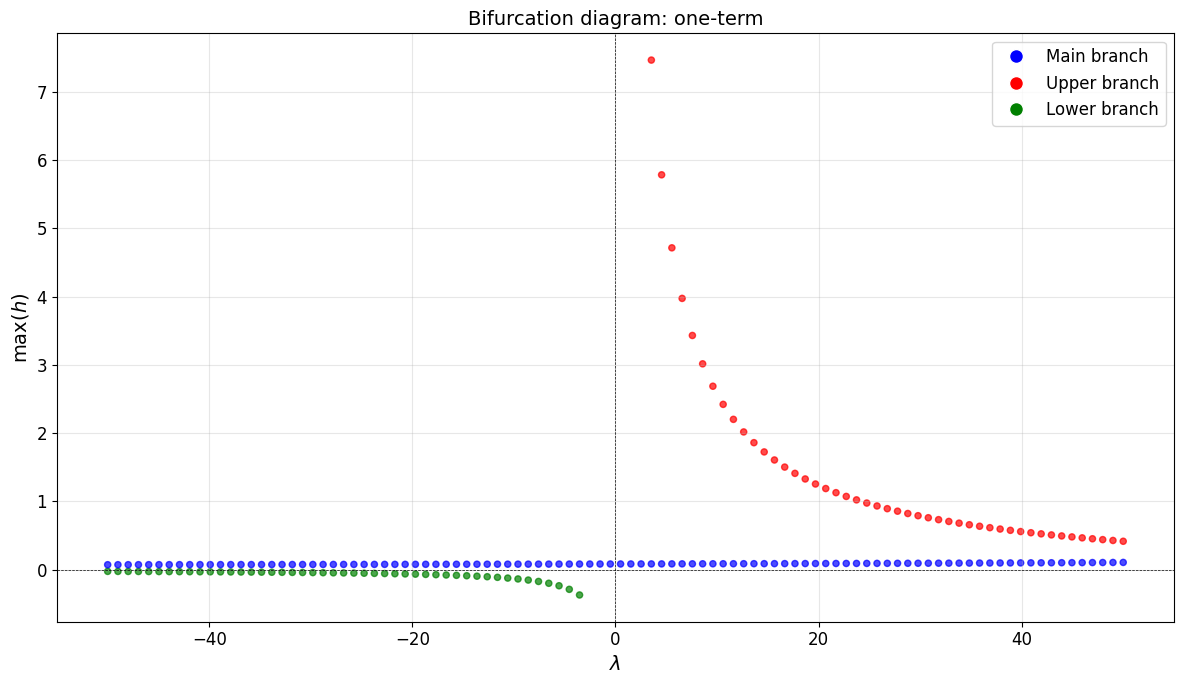

In [62]:
fig, ax = plt.subplots(figsize=(12, 7))

colors = []
for h_max in h_max_scatter:
    if h_max < -0.01:
        colors.append('green')  # lower branch
    elif h_max > 0.15:
        colors.append('red')    # upper branch
    else:
        colors.append('blue')   # main branch

ax.scatter(lam_scatter, h_max_scatter, c=colors, s=20, alpha=0.7)
ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--')

ax.set_xlabel(r'$\lambda$', fontsize=14)
ax.set_ylabel(r'$\max(h)$', fontsize=14)
ax.set_title('Bifurcation diagram: one-term', fontsize=14)
ax.grid(True, alpha=0.3)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Main branch'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Upper branch'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Lower branch')
]
ax.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
plt.show()

Observation: additional solution branches appear when $|\lambda| > \lambda*$.


### Step 5: Search for Multiple Solution Branches

The bifurcation diagram shows a solution branch that goes to large values. Let's look more carefully at the structure and search for additional branches by using different initial guesses.

In [63]:
# Scan different values
lambda_test_values = [-50, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 50]

print("Searching for multiple solutions at different lambda values:\n")
print(f"{'lambda':>8} | {'# Solutions':>12} | {'max(h) values':>10}")
print("-" * 45)

for lam_val in lambda_test_values:
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=30)
    max_vals = sorted([np.max(s) for s in sols])
    max_str = ", ".join([f"{v:.4f}" for v in max_vals[:5]])  # Show first 5
    print(f"{lam_val:>8} | {len(sols):>12} | {max_str}")

Searching for multiple solutions at different lambda values:

  lambda |  # Solutions | max(h) values
---------------------------------------------
     -50 |            2 | -0.0264, 0.0710
     -20 |            2 | -0.0662, 0.0768
     -10 |            2 | -0.1320, 0.0792
      -5 |            2 | -0.2634, 0.0805
      -2 |            1 | 0.0813
      -1 |            1 | 0.0816
       0 |            1 | 0.0819
       1 |            1 | 0.0822
       2 |            1 | 0.0825
       5 |            2 | 0.0834, 5.2484
      10 |            2 | 0.0850, 2.5733
      20 |            2 | 0.0885, 1.2330
      50 |            2 | 0.1048, 0.4147


In [64]:
# Check different lambdas

sols_lam5 = find_all_solutions_at_lambda(5.0, N, dx, x_interior, num_trials=30)
print(f"Lambda = 5: found {len(sols_lam5)} solutions:")
for i, sol in enumerate(sols_lam5):
    print(f"Solution {i+1}: max(h) = {np.max(sol):.6f}")

# Solution with the largest amplitude
if len(sols_lam5) > 0:
    large_amp_sol = max(sols_lam5, key=lambda s: np.max(s))
    print(f"\nSolution with the maximum amplitude: max(h) = {np.max(large_amp_sol):.6f}")


Lambda = 5: found 2 solutions:
Solution 1: max(h) = 0.083365
Solution 2: max(h) = 5.248363

Solution with the maximum amplitude: max(h) = 5.248363


In [65]:
# Check the negative branch for lambda < 0
sols_lam_neg = find_all_solutions_at_lambda(-10.0, N, dx, x_interior, num_trials=30)
print(f"Lambda = -10: found {len(sols_lam_neg)} solutions:")
for i, sol in enumerate(sols_lam_neg):
    print(f"Solution {i+1}: max(h) = {np.max(sol):.6f}, min(h) = {np.min(sol):.6f}")

# Solution with a negative maximum (if exists)
if len(sols_lam_neg) > 1:
    neg_sol = min(sols_lam_neg, key=lambda s: np.max(s))
    print(f"\nNegative solution: max(h) = {np.max(neg_sol):.6f}")


Lambda = -10: found 2 solutions:
Solution 1: max(h) = -0.131976, min(h) = -2.768058
Solution 2: max(h) = 0.079202, min(h) = 0.007180

Negative solution: max(h) = -0.131976


### Step 5: Complete bifurcation diagram

We construct the complete bifurcation diagram by scanning over lambda on an extended parameter range and classifying the solution branches.

In [66]:
lambda_scan = np.linspace(-N, N, 200)
all_solutions_data = []  # List of (λ, max(h), solution) tuples

print("Scanning for all solutions across lambda range...")
for i, lam_val in enumerate(lambda_scan):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=25)
    for sol in sols:
        all_solutions_data.append((lam_val, np.max(sol), sol.copy()))
    
    if (i + 1) % 40 == 0:
        print(f"Processed {i+1}/{len(lambda_scan)} λ values...")

print(f"Total solution points found: {len(all_solutions_data)}")

lam_scatter = np.array([d[0] for d in all_solutions_data])
h_max_scatter = np.array([d[1] for d in all_solutions_data])

Scanning for all solutions across lambda range...
Processed 40/200 λ values...
Processed 80/200 λ values...
Processed 120/200 λ values...
Processed 160/200 λ values...
Processed 200/200 λ values...
Total solution points found: 390


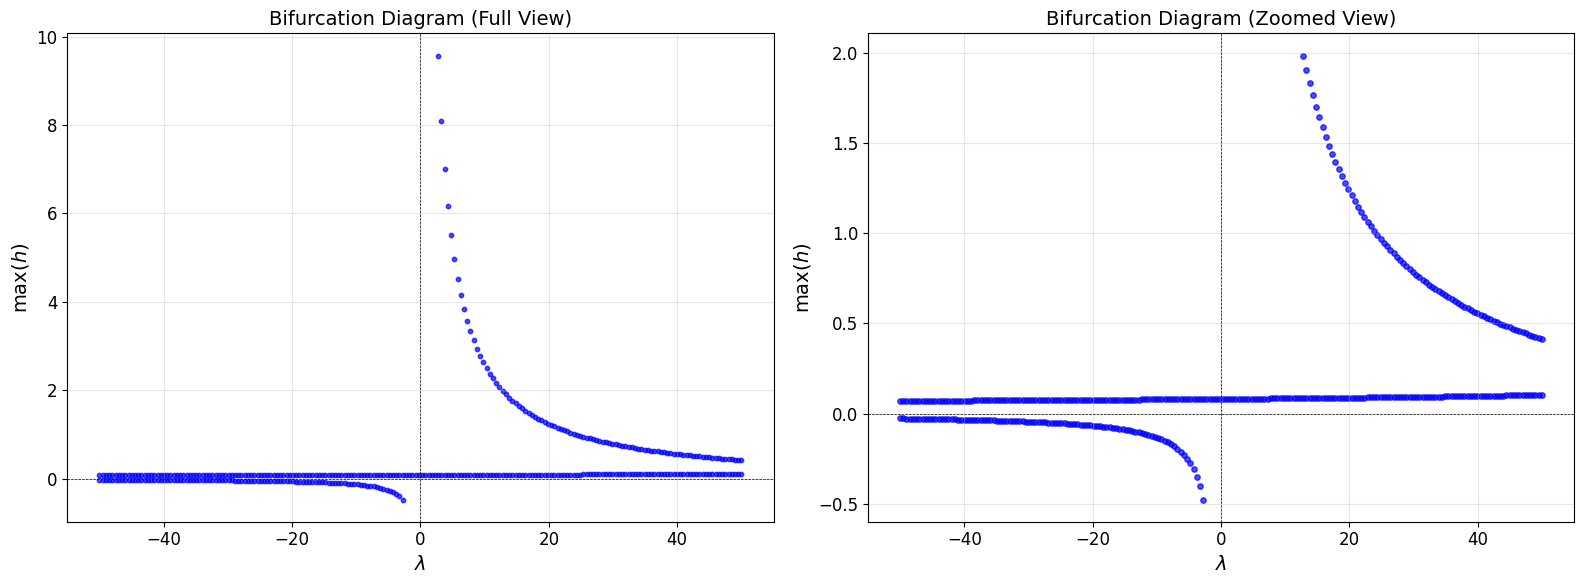

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Full view
ax1 = axes[0]
ax1.scatter(lam_scatter, h_max_scatter, c='blue', s=10, alpha=0.7)
ax1.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax1.axvline(x=0, color='k', linewidth=0.5, linestyle='--')
ax1.set_xlabel(r'$\lambda$', fontsize=14)
ax1.set_ylabel(r'$\max(h)$', fontsize=14)
ax1.set_title('Bifurcation Diagram (Full View)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Right: Zoomed view to see structure
ax2 = axes[1]
mask = (h_max_scatter > -1) & (h_max_scatter < 2)
ax2.scatter(lam_scatter[mask], h_max_scatter[mask], c='blue', s=15, alpha=0.7)
ax2.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax2.axvline(x=0, color='k', linewidth=0.5, linestyle='--')
ax2.set_xlabel(r'$\lambda$', fontsize=14)
ax2.set_ylabel(r'$\max(h)$', fontsize=14)
ax2.set_title('Bifurcation Diagram (Zoomed View)', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 7: Analyze the Bifurcation Structure

From the bifurcation diagram, we can identify the following features:

1. **Main branch** (small amplitude, nearly constant): exists for all λ
2. **Upper branch** (large positive amplitude): exists for λ > λ* (some critical value)
3. **Lower branch** (negative amplitude): exists for λ < λ** (another critical value)

The branches meet at **fold bifurcations** (turning points). Let's identify these critical λ values and visualize the different solution types.

In [68]:
# Analyze the branches more carefully
# Separate solutions into branches based on max(h) values

# Create a finer scan near the turning points
lambda_fine = np.linspace(-5, 20, 100)
branch_data = {
    'lower': {'lam': [], 'h_max': []},
    'middle': {'lam': [], 'h_max': []},
    'upper': {'lam': [], 'h_max': []}
}

for lam_val in lambda_fine:
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=35)
    max_vals = sorted([np.max(s) for s in sols])
    
    if len(max_vals) >= 1:
        # Classify based on magnitude
        for h_max_val in max_vals:
            if h_max_val < -0.01:  # Lower branch (negative)
                branch_data['lower']['lam'].append(lam_val)
                branch_data['lower']['h_max'].append(h_max_val)
            elif h_max_val > 0.2:  # Upper branch (large positive)
                branch_data['upper']['lam'].append(lam_val)
                branch_data['upper']['h_max'].append(h_max_val)
            else:  # Middle branch (small positive)
                branch_data['middle']['lam'].append(lam_val)
                branch_data['middle']['h_max'].append(h_max_val)

# Find critical lambda values (turning points)
if len(branch_data['lower']['lam']) > 0:
    lambda_lower_turning = max(branch_data['lower']['lam'])
    print(f"Lower branch turning point: lambda ≈ {lambda_lower_turning:.3f}")

if len(branch_data['upper']['lam']) > 0:
    lambda_upper_turning = min(branch_data['upper']['lam'])
    print(f"Upper branch turning point: lambda ≈ {lambda_upper_turning:.3f}")

Lower branch turning point: lambda ≈ -2.727
Upper branch turning point: lambda ≈ 2.828


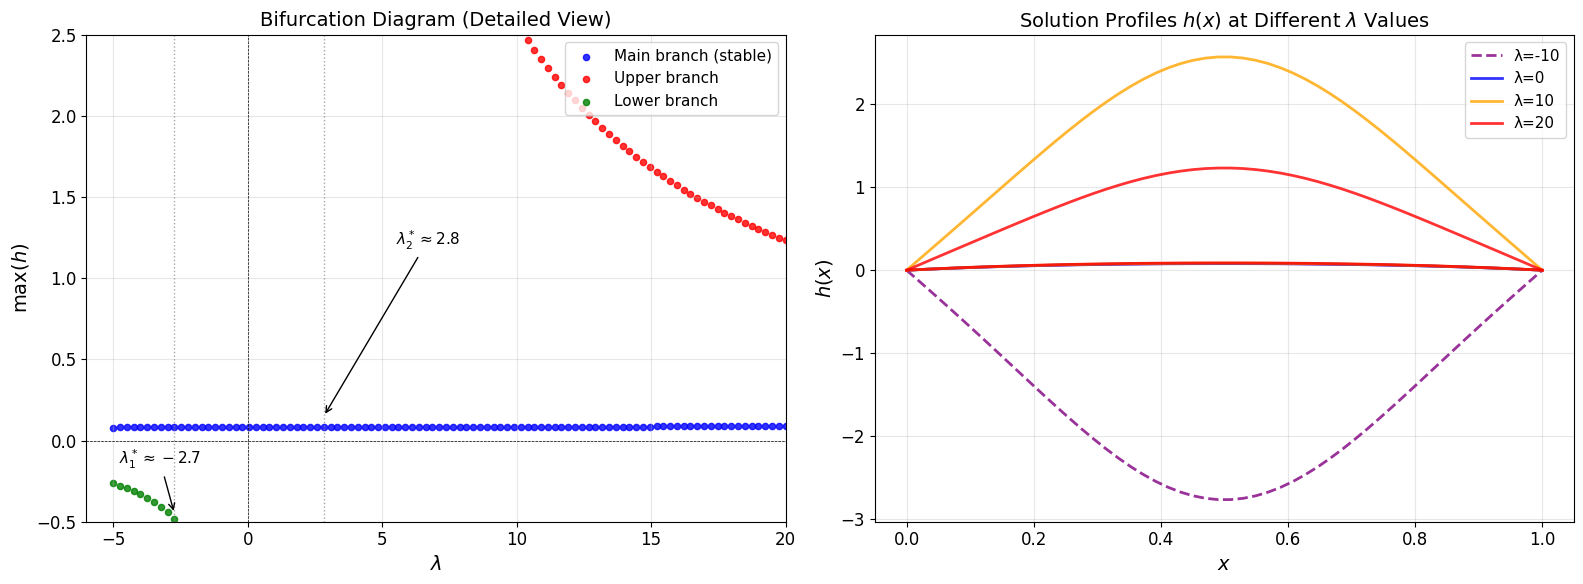

In [69]:
# Create detailed bifurcation diagram with branches colored
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Bifurcation diagram with colored branches
ax1 = axes[0]

# Plot each branch
ax1.scatter(branch_data['middle']['lam'], branch_data['middle']['h_max'], 
            c='blue', s=20, alpha=0.8, label='Main branch (stable)')
ax1.scatter(branch_data['upper']['lam'], branch_data['upper']['h_max'], 
            c='red', s=20, alpha=0.8, label='Upper branch')
ax1.scatter(branch_data['lower']['lam'], branch_data['lower']['h_max'], 
            c='green', s=20, alpha=0.8, label='Lower branch')

# Mark turning points
ax1.axvline(x=-2.727, color='gray', linewidth=1, linestyle=':', alpha=0.7)
ax1.axvline(x=2.828, color='gray', linewidth=1, linestyle=':', alpha=0.7)

ax1.annotate(
    r'$\lambda_1^* \approx -2.7$',
    xy=(-2.727, -0.45),      # точка на линии
    xytext=(-4.8, -0.15),    # где текст
    arrowprops=dict(arrowstyle='->', lw=1),
    fontsize=11
)

ax1.annotate(
    r'$\lambda_2^* \approx 2.8$',
    xy=(2.828, 0.15),
    xytext=(5.5, 1.2),
    arrowprops=dict(arrowstyle='->', lw=1),
    fontsize=11
)


ax1.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax1.axvline(x=0, color='k', linewidth=0.5, linestyle='--')
ax1.set_xlabel(r'$\lambda$', fontsize=14)
ax1.set_ylabel(r'$\max(h)$', fontsize=14)
ax1.set_title('Bifurcation Diagram (Detailed View)', fontsize=14)
ax1.set_xlim(-6, 20)
ax1.set_ylim(-0.5, 2.5)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11, loc='upper right')

# Right: Solution profiles at different λ values
ax2 = axes[1]
x_full = np.linspace(0, 1, N + 2)  # Include boundary points

# Select representative λ values
test_lambdas = [-10, 0, 10, 20]
colors = ['purple', 'blue', 'orange', 'red']

for lam_val, color in zip(test_lambdas, colors):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=30)
    for i, sol in enumerate(sols):
        h_full = np.concatenate([[0], sol, [0]])  # Add boundary values
        linestyle = '-' if np.max(sol) > 0 else '--'
        label = f'λ={lam_val}' if i == 0 else None
        ax2.plot(x_full, h_full, color=color, linestyle=linestyle, 
                 linewidth=2, alpha=0.8, label=label)

ax2.set_xlabel(r'$x$', fontsize=14)
ax2.set_ylabel(r'$h(x)$', fontsize=14)
ax2.set_title(r'Solution Profiles $h(x)$ at Different $\lambda$ Values', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

### Step 8: Visualize the 2D Solutions

The full 2D solution is reconstructed as: $u(x,y) = h(x) \sin(\pi y)$. Let's visualize these solutions for different parameter values and different branches.

In [70]:
def plot_2d_solution(h, title, ax):
    """
    Plot the 2D solution u(x,y) = h(x) * sin(πy)
    """
    # Full grid including boundaries
    x = np.linspace(0, 1, N + 2)
    y = np.linspace(0, 1, 101)
    X, Y = np.meshgrid(x, y)
    
    # Add boundary values to h
    h_full = np.concatenate([[0], h, [0]])
    
    # Compute u(x,y) = h(x) * sin(πy)
    U = np.outer(np.sin(np.pi * y), h_full)
    
    # Plot
    im = ax.contourf(X, Y, U, levels=50, cmap='RdBu_r')
    ax.set_xlabel(r'$x$', fontsize=12)
    ax.set_ylabel(r'$y$', fontsize=12)
    ax.set_title(title, fontsize=12)
    ax.set_aspect('equal')
    return im

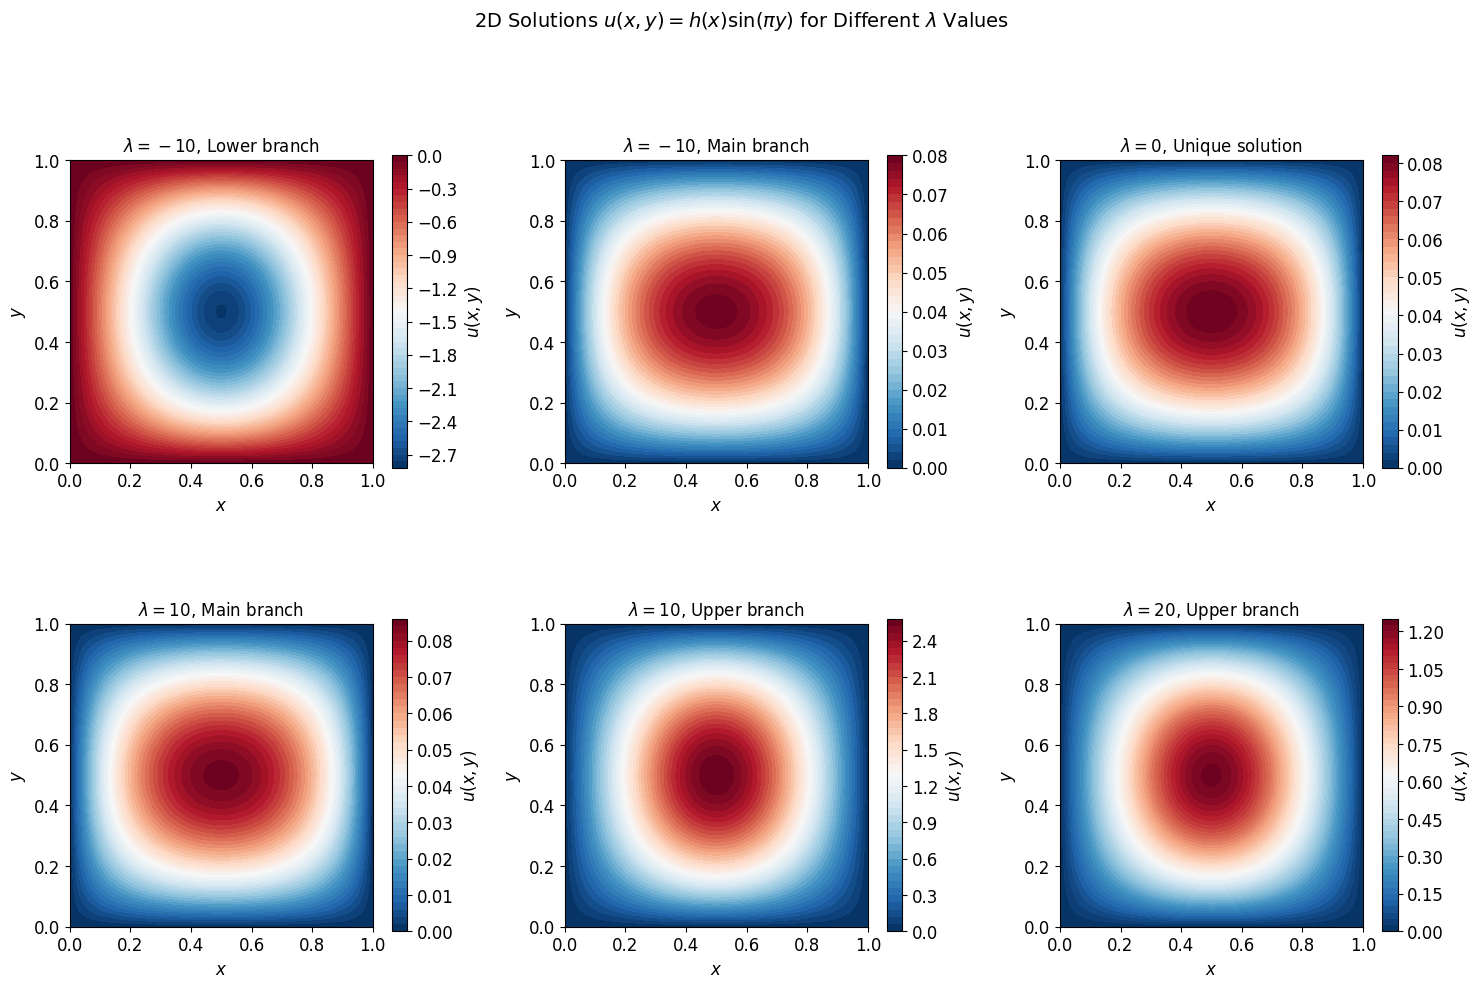

In [71]:
# Select representative cases
cases = [
    (-10, 'Lower branch at lambda=-10'),
    (-10, 'Main branch at lambda=-10'),
    (0, 'Unique solution at lambda=0'),
    (10, 'Main branch at lambda=10'),
    (10, 'Upper branch at lambda=10'),
    (20, 'Upper branch at lambda=20')
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Get solutions
solutions_to_plot = []

# λ = -10: lower and main branches
sols_neg10 = find_all_solutions_at_lambda(-10, N, dx, x_interior, num_trials=30)
sols_neg10_sorted = sorted(sols_neg10, key=lambda s: np.max(s))
if len(sols_neg10_sorted) >= 2:
    solutions_to_plot.append((sols_neg10_sorted[0], r'$\lambda=-10$, Lower branch'))
    solutions_to_plot.append((sols_neg10_sorted[-1], r'$\lambda=-10$, Main branch'))
elif len(sols_neg10_sorted) == 1:
    solutions_to_plot.append((sols_neg10_sorted[0], r'$\lambda=-10$'))

# λ = 0: unique solution
sols_0 = find_all_solutions_at_lambda(0, N, dx, x_interior, num_trials=30)
solutions_to_plot.append((sols_0[0], r'$\lambda=0$, Unique solution'))

# λ = 10: main and upper branches
sols_10 = find_all_solutions_at_lambda(10, N, dx, x_interior, num_trials=30)
sols_10_sorted = sorted(sols_10, key=lambda s: np.max(s))
if len(sols_10_sorted) >= 2:
    solutions_to_plot.append((sols_10_sorted[0], r'$\lambda=10$, Main branch'))
    solutions_to_plot.append((sols_10_sorted[-1], r'$\lambda=10$, Upper branch'))

# λ = 20
sols_20 = find_all_solutions_at_lambda(20, N, dx, x_interior, num_trials=30)
sols_20_sorted = sorted(sols_20, key=lambda s: np.max(s))
if len(sols_20_sorted) >= 2:
    solutions_to_plot.append((sols_20_sorted[-1], r'$\lambda=20$, Upper branch'))

# Plot all
for i, (sol, title) in enumerate(solutions_to_plot[:6]):
    im = plot_2d_solution(sol, title, axes[i])
    plt.colorbar(im, ax=axes[i], shrink=0.7, label=r'$u(x,y)$')

# Hide unused axes
for i in range(len(solutions_to_plot), 6):
    axes[i].axis('off')

plt.suptitle(r'2D Solutions $u(x,y) = h(x)\sin(\pi y)$ for Different $\lambda$ Values', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

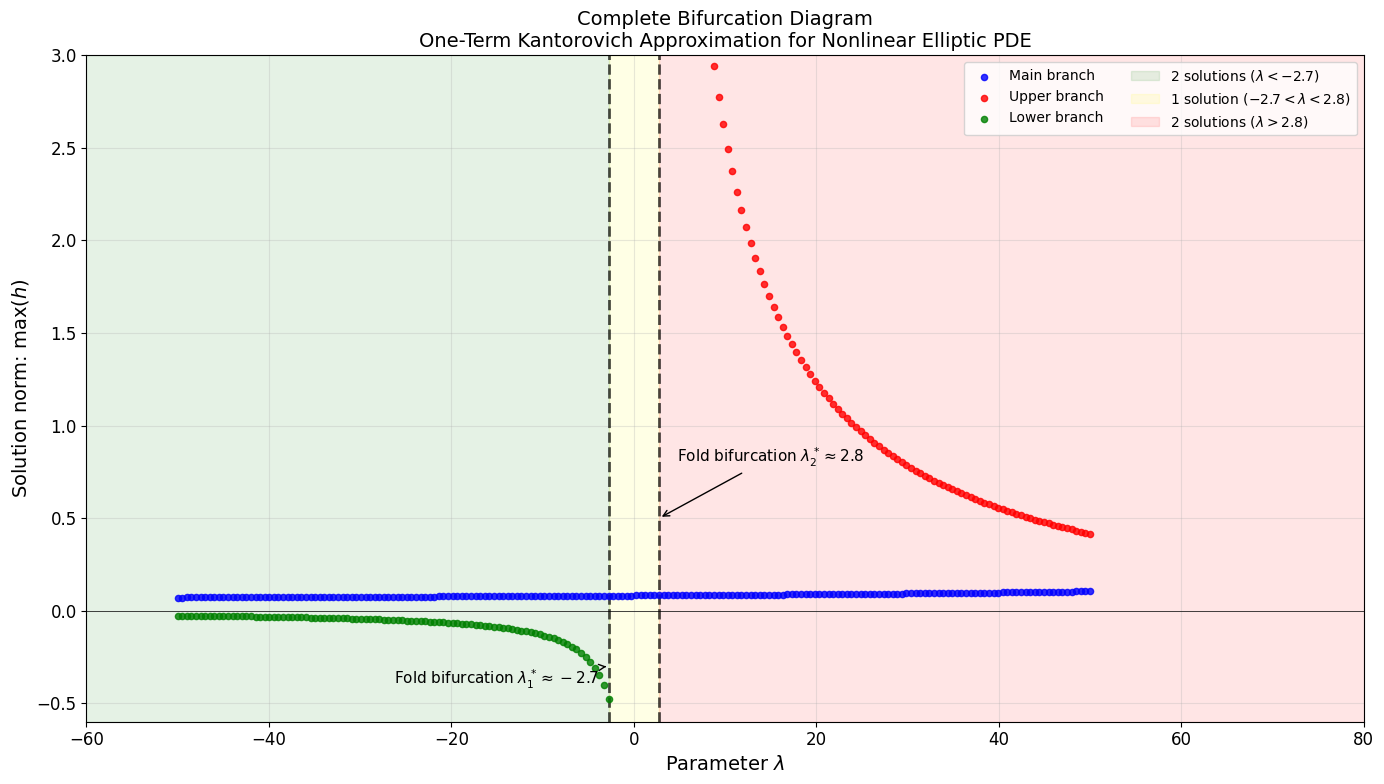

In [72]:
# Create final comprehensive bifurcation diagram
fig, ax = plt.subplots(figsize=(14, 8))

# Plot all found solutions with different colors for branches
# Separate by max(h) value
lower_mask = h_max_scatter < -0.01
middle_mask = (h_max_scatter >= -0.01) & (h_max_scatter < 0.15)
upper_mask = h_max_scatter >= 0.15

ax.scatter(lam_scatter[middle_mask], h_max_scatter[middle_mask], 
           c='blue', s=20, alpha=0.8, label='Main branch', zorder=3)
ax.scatter(lam_scatter[upper_mask], h_max_scatter[upper_mask], 
           c='red', s=20, alpha=0.8, label='Upper branch', zorder=3)
ax.scatter(lam_scatter[lower_mask], h_max_scatter[lower_mask], 
           c='green', s=20, alpha=0.8, label='Lower branch', zorder=3)

# Mark critical λ values with shaded regions
ax.axvspan(-100, -2.7, alpha=0.1, color='green', label=r'2 solutions ($\lambda < -2.7$)')
ax.axvspan(-2.7, 2.8, alpha=0.1, color='yellow', label=r'1 solution ($-2.7 < \lambda < 2.8$)')
ax.axvspan(2.8, 100, alpha=0.1, color='red', label=r'2 solutions ($\lambda > 2.8$)')

# Mark bifurcation points
ax.axvline(x=-2.7, color='black', linewidth=2, linestyle='--', alpha=0.7)
ax.axvline(x=2.8, color='black', linewidth=2, linestyle='--', alpha=0.7)

# Annotations
ax.annotate(r'Fold bifurcation $\lambda_1^* \approx -2.7$', 
            xy=(-2.7, -0.3), xytext=(-15, -0.4),
            fontsize=11, ha='center',
            arrowprops=dict(arrowstyle='->', color='black'))
ax.annotate(r'Fold bifurcation $\lambda_2^* \approx 2.8$', 
            xy=(2.8, 0.5), xytext=(15, 0.8),
            fontsize=11, ha='center',
            arrowprops=dict(arrowstyle='->', color='black'))

ax.axhline(y=0, color='k', linewidth=0.5, linestyle='-')

ax.set_xlabel(r'Parameter $\lambda$', fontsize=14)
ax.set_ylabel(r'Solution norm: $\max(h)$', fontsize=14)
ax.set_title('Complete Bifurcation Diagram\nOne-Term Kantorovich Approximation for Nonlinear Elliptic PDE', fontsize=14)
ax.set_xlim(-60, 80)
ax.set_ylim(-0.6, 3)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

## Step 9: Verification - Refine Bifurcation Points

Let's refine the critical $\lambda$ values by searching more precisely.

In [73]:
# Refine the first bifurcation point (λ₁* where lower branch disappears)
def count_solutions(lam_val):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=40)
    return len(sols)

# Binary search for λ₁* (transition from 2 to 1 solutions)
lam_left, lam_right = -5.0, 0.0
for _ in range(15):
    lam_mid = (lam_left + lam_right) / 2
    n_sols = count_solutions(lam_mid)
    if n_sols >= 2:
        lam_left = lam_mid  # More solutions on left
    else:
        lam_right = lam_mid

lambda_1_star = (lam_left + lam_right) / 2
print(f"Refined lambda_1* (lower branch turning point): {lambda_1_star:.4f}")

# Binary search for λ₂* (transition from 1 to 2 solutions)
lam_left, lam_right = 0.0, 10.0
for _ in range(15):
    lam_mid = (lam_left + lam_right) / 2
    n_sols = count_solutions(lam_mid)
    if n_sols >= 2:
        lam_right = lam_mid  # More solutions on right
    else:
        lam_left = lam_mid

lambda_2_star = (lam_left + lam_right) / 2
print(f"Refined lamdba_2* (upper branch turning point): {lambda_2_star:.4f}")

# Verify by counting solutions near the bifurcation points
print("\nVerification:")
for lam_test in [lambda_1_star - 0.5, lambda_1_star + 0.5, lambda_2_star - 0.5, lambda_2_star + 0.5]:
    n = count_solutions(lam_test)
    print(f"Lambda = {lam_test:.2f}: {n} solution(s)")

Refined lambda_1* (lower branch turning point): -2.5773
Refined lamdba_2* (upper branch turning point): 2.5774

Verification:
Lambda = -3.08: 2 solution(s)
Lambda = -2.08: 1 solution(s)
Lambda = 2.08: 1 solution(s)
Lambda = 3.08: 2 solution(s)


### Step 10: Detailed Bifurcation Diagram (L2 norm and Maximum)

Now let's create a more detailed bifurcation diagram similar to the reference, showing:
- Branch 1 (symmetric) 
- Branch 2 (asymmetric)
- Branch 3 (large amplitude)

With both $\|u\|_2$ (L2 norm) and $\max(u)$ on the y-axis.

In [74]:
# Compute L2 norm for the full 2D solution u(x,y) = h(x)*sin(πy)
def compute_L2_norm(h, dx):
    h_full = np.concatenate([[0], h, [0]])  # Add boundary values
    h_L2_squared = np.trapezoid(h_full**2, dx=dx)
    # Integral of sin^2(πy) from 0 to 1 = 1/2
    u_L2_squared = h_L2_squared * 0.5
    return np.sqrt(u_L2_squared)

In [75]:
def compute_max_u(h):
    return np.max(np.abs(h))

In [76]:
lambda_detailed = np.linspace(-50, 50, 300)

# Storage for all branches
branch1_data = {'lam': [], 'L2': [], 'max_u': [], 'sols': []}  # Symmetric (small)
branch2_data = {'lam': [], 'L2': [], 'max_u': [], 'sols': []}  # Asymmetric (medium)
branch3_data = {'lam': [], 'L2': [], 'max_u': [], 'sols': []}  # Large amplitude

print("Scanning for solutions:")

for i, lam_val in enumerate(lambda_detailed):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=40)
    
    # Sort solutions by max value
    sols_sorted = sorted(sols, key=lambda s: np.max(s))
    
    for sol in sols_sorted:
        L2_norm = compute_L2_norm(sol, dx)
        max_u = np.max(sol)  # Can be positive or negative
        
        # Classify into branches based on amplitude characteristics
        if max_u < 0:
            # Negative solutions - this could be Branch 2 (asymmetric-like)
            branch2_data['lam'].append(lam_val)
            branch2_data['L2'].append(L2_norm)
            branch2_data['max_u'].append(max_u)
            branch2_data['sols'].append(sol)
        elif max_u < 0.15:
            # Small positive - Branch 1 (symmetric, main)
            branch1_data['lam'].append(lam_val)
            branch1_data['L2'].append(L2_norm)
            branch1_data['max_u'].append(max_u)
            branch1_data['sols'].append(sol)
        else:
            # Large positive - Branch 3 (large amplitude)
            branch3_data['lam'].append(lam_val)
            branch3_data['L2'].append(L2_norm)
            branch3_data['max_u'].append(max_u)
            branch3_data['sols'].append(sol)
    
    if (i + 1) % 30 == 0:
        print(f"Processed {i+1}/{len(lambda_detailed)} lambda values...")

print(f"\nBranch 1 (symmetric): {len(branch1_data['lam'])} points")
print(f"Branch 2 (asymmetric): {len(branch2_data['lam'])} points")
print(f"Branch 3 (large amplitude): {len(branch3_data['lam'])} points")

Scanning for solutions:
Processed 30/300 lambda values...
Processed 60/300 lambda values...
Processed 90/300 lambda values...
Processed 120/300 lambda values...
Processed 150/300 lambda values...
Processed 180/300 lambda values...
Processed 210/300 lambda values...
Processed 240/300 lambda values...
Processed 270/300 lambda values...
Processed 300/300 lambda values...

Branch 1 (symmetric): 300 points
Branch 2 (asymmetric): 142 points
Branch 3 (large amplitude): 142 points


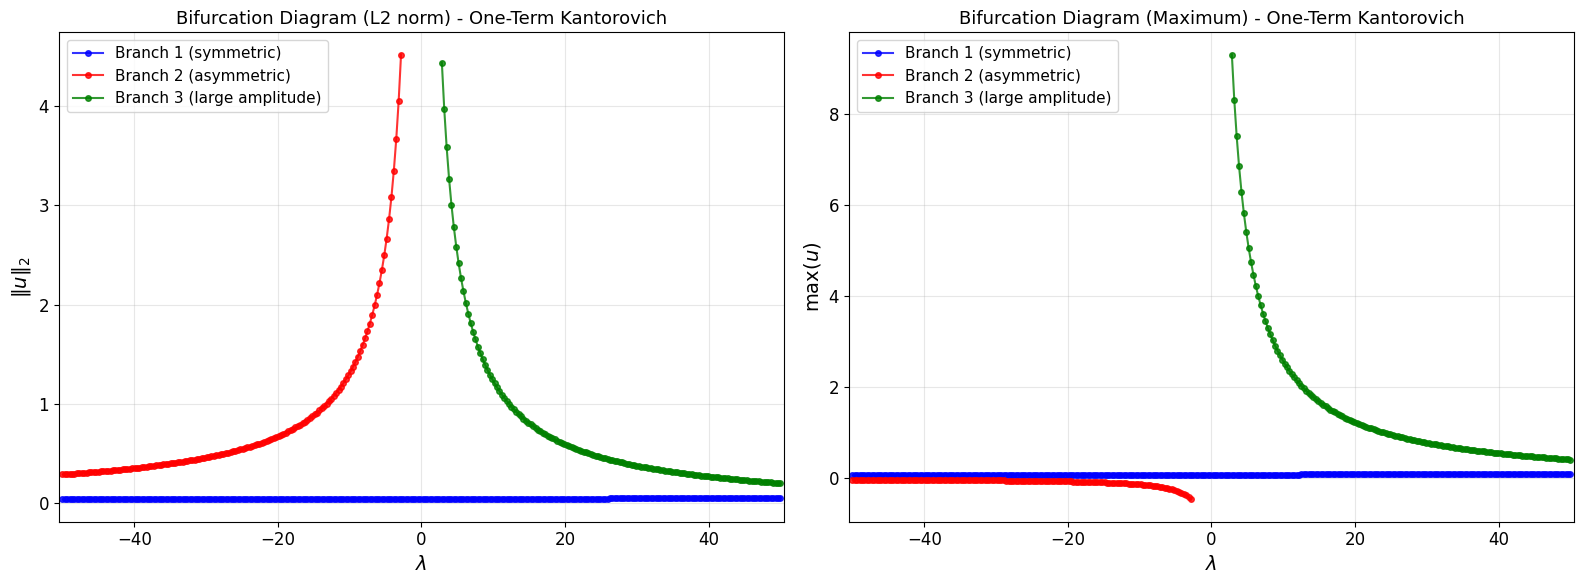

In [77]:
# Create bifurcation diagram similar to reference
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: L2 norm
ax1 = axes[0]

# Plot each branch with markers and lines
if len(branch1_data['lam']) > 0:
    # Sort by lambda for proper line plotting
    idx1 = np.argsort(branch1_data['lam'])
    lam1 = np.array(branch1_data['lam'])[idx1]
    L2_1 = np.array(branch1_data['L2'])[idx1]
    ax1.plot(lam1, L2_1, 'b-o', markersize=4, linewidth=1.5, 
             label='Branch 1 (symmetric)', alpha=0.8)

if len(branch2_data['lam']) > 0:
    idx2 = np.argsort(branch2_data['lam'])
    lam2 = np.array(branch2_data['lam'])[idx2]
    L2_2 = np.array(branch2_data['L2'])[idx2]
    ax1.plot(lam2, L2_2, 'r-o', markersize=4, linewidth=1.5, 
             label='Branch 2 (asymmetric)', alpha=0.8)

if len(branch3_data['lam']) > 0:
    idx3 = np.argsort(branch3_data['lam'])
    lam3 = np.array(branch3_data['lam'])[idx3]
    L2_3 = np.array(branch3_data['L2'])[idx3]
    ax1.plot(lam3, L2_3, 'g-o', markersize=4, linewidth=1.5, 
             label='Branch 3 (large amplitude)', alpha=0.8)

ax1.set_xlabel(r'$\lambda$', fontsize=14)
ax1.set_ylabel(r'$\|u\|_2$', fontsize=14)
ax1.set_title('Bifurcation Diagram (L2 norm) - One-Term Kantorovich', fontsize=13)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-50.5, 50.5)

# Right plot: max(u)
ax2 = axes[1]

if len(branch1_data['lam']) > 0:
    max_u1 = np.array(branch1_data['max_u'])[idx1]
    ax2.plot(lam1, max_u1, 'b-o', markersize=4, linewidth=1.5, 
             label='Branch 1 (symmetric)', alpha=0.8)

if len(branch2_data['lam']) > 0:
    max_u2 = np.array(branch2_data['max_u'])[idx2]
    ax2.plot(lam2, max_u2, 'r-o', markersize=4, linewidth=1.5, 
             label='Branch 2 (asymmetric)', alpha=0.8)

if len(branch3_data['lam']) > 0:
    max_u3 = np.array(branch3_data['max_u'])[idx3]
    ax2.plot(lam3, max_u3, 'g-o', markersize=4, linewidth=1.5, 
             label='Branch 3 (large amplitude)', alpha=0.8)

ax2.set_xlabel(r'$\lambda$', fontsize=14)
ax2.set_ylabel(r'$\max(u)$', fontsize=14)
ax2.set_title('Bifurcation Diagram (Maximum) - One-Term Kantorovich', fontsize=13)
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-50.5, 50.5)

plt.tight_layout()
plt.show()

The one-term Kantorovich approximation u(x,y) = h(x)sin(πy) produces solutions that are symmetric in x about x=0.5.

The 'asymmetric' branch here refers to negative-amplitude solutions.

# Problem 3: Numerical Bifurcation Analysis with Two-Term Kantorovich Method

## Two-Term System


**Equation 1:**
$$h_1'' + (1-\pi^2)h_1 + \frac{4}{\pi} + \lambda\left(\frac{8}{3\pi}h_1^2 + \frac{32}{15\pi}h_2^2\right) = 0$$

**Equation 2:**
$$h_2'' + (1-4\pi^2)h_2 + \lambda\frac{32}{15\pi}h_1 h_2 = 0$$

In [78]:
# I computed coefficients for the two-term Kantorovich approximation
alpha1_2t = 1 - np.pi**2
beta1_2t = 4 / np.pi
gamma11_2t = 8 / (3 * np.pi)
gamma12_2t = 32 / (15 * np.pi)

alpha2_2t = 1 - 4 * np.pi**2
beta2_2t = 0
gamma21_2t = 64 / (15 * np.pi)

# Grid for two-term system
N_2term = 50
dx_2term = 1 / (N_2term + 1)
x_interior_2term = np.linspace(dx_2term, 1 - dx_2term, N_2term)

In [79]:
def residual_2term(z, lam, N, dx):
    """
    Residual for the two-term coupled system.
    z = [h1, h2] concatenated
    """
    h1 = z[:N]
    h2 = z[N:]
    
    F = np.zeros(2 * N)
    
    for i in range(N):
        h1_left = 0 if i == 0 else h1[i-1]
        h1_right = 0 if i == N-1 else h1[i+1]
        h1_xx = (h1_left - 2*h1[i] + h1_right) / dx**2
        
        F[i] = h1_xx + alpha1_2t * h1[i] + beta1_2t + lam * (gamma11_2t * h1[i]**2 + gamma12_2t * h2[i]**2)
    
    for i in range(N):
        h2_left = 0 if i == 0 else h2[i-1]
        h2_right = 0 if i == N-1 else h2[i+1]
        h2_xx = (h2_left - 2*h2[i] + h2_right) / dx**2
        
        F[N + i] = h2_xx + alpha2_2t * h2[i] + lam * gamma21_2t * h1[i] * h2[i]
    
    return F

In [80]:
def jacobian_2term(z, lam, N, dx):
    """
    Jacobian for the two-term system.
    """
    h1 = z[:N]
    h2 = z[N:]
    
    J = np.zeros((2*N, 2*N))
    
    for i in range(N):
        J[i, i] = -2/dx**2 + alpha1_2t + 2*lam*gamma11_2t*h1[i]
        if i > 0:
            J[i, i-1] = 1/dx**2
        if i < N-1:
            J[i, i+1] = 1/dx**2
    
    for i in range(N):
        J[i, N + i] = 2*lam*gamma12_2t*h2[i]
    
    for i in range(N):
        J[N + i, i] = lam*gamma21_2t*h2[i]
    
    for i in range(N):
        J[N + i, N + i] = -2/dx**2 + alpha2_2t + lam*gamma21_2t*h1[i]
        if i > 0:
            J[N + i, N + i - 1] = 1/dx**2
        if i < N-1:
            J[N + i, N + i + 1] = 1/dx**2
    
    return J

In [81]:
def newton_solve_2term(z0, lam, N, dx, tol=1e-10, max_iter=100):
    """
    Newton solver for two-term system.
    """
    z = z0.copy()
    
    for k in range(max_iter):
        F = residual_2term(z, lam, N, dx)
        norm_F = np.linalg.norm(F)
        
        if norm_F < tol:
            return z, True
        
        J = jacobian_2term(z, lam, N, dx)
        
        try:
            delta_z = solve(J, -F)
        except np.linalg.LinAlgError:
            return z, False
        
        z = z + delta_z
    
    return z, False

In [82]:
def find_all_solutions_2term(lam_val, N, dx, x_interior, num_trials=20):
    """
    Find all solutions at a given lambda using different initial guesses.
    """
    solutions = []
    
    amplitudes_h1 = np.linspace(-2, 5, num_trials)
    amplitudes_h2 = np.linspace(-0.5, 0.5, 5)
    
    for amp1 in amplitudes_h1:
        for amp2 in amplitudes_h2:
            h1_init = amp1 * np.sin(np.pi * x_interior)
            h2_init = amp2 * np.sin(2 * np.pi * x_interior)
            z0_trial = np.concatenate([h1_init, h2_init])
            
            z_sol, converged = newton_solve_2term(z0_trial, lam_val, N, dx, max_iter=200)
            
            if converged:
                is_new = True
                for z_existing in solutions:
                    if np.linalg.norm(z_sol - z_existing) < 1e-4:
                        is_new = False
                        break
                if is_new:
                    solutions.append(z_sol.copy())
    
    return solutions

In [83]:
# Test at lambda = 0
z0_test = np.concatenate([0.1 * np.sin(np.pi * x_interior_2term), 
                          0.0 * np.sin(2 * np.pi * x_interior_2term)])
z_sol, converged = newton_solve_2term(z0_test, 0.0, N_2term, dx_2term)

print(f"Test at lambda = 0:")
print(f"Converged: {converged}")
print(f"max(h_1) = {np.max(z_sol[:N_2term]):.6f}")
print(f"max(|h_2|) = {np.max(np.abs(z_sol[N_2term:])):.6e}")

Test at lambda = 0:
Converged: True
max(h_1) = 0.081885
max(|h_2|) = 0.000000e+00


In [84]:
print("Comparison: One-Term vs Two-Term Kantorovich Method\n")
print(f"{'lambda':>8} | {'1-term #':>10} | {'1-term max(h)':>20} | {'2-term #':>10} | {'2-term max(h₁)':>20}")
print("-" * 90)

test_lambdas = [-10, -5, -3, -2.5, 0, 2.5, 3, 5, 10]

for lam_val in test_lambdas:
    # One-term
    sols_1t = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=40)
    n_1t = len(sols_1t)
    max_1t = sorted([np.max(s) for s in sols_1t])
    max_1t_str = ", ".join([f"{v:.4f}" for v in max_1t[:3]])
    
    # Two-term
    sols_2t = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=25)
    n_2t = len(sols_2t)
    max_2t = sorted([np.max(s[:N_2term]) for s in sols_2t])
    max_2t_str = ", ".join([f"{v:.4f}" for v in max_2t[:3]])
    
    match = "OK" if n_1t == n_2t else "NOT OK"
    print(f"{lam_val:>8} | {n_1t:>10} | {max_1t_str:>20} | {n_2t:>10} | {max_2t_str:>20} {match}")

Comparison: One-Term vs Two-Term Kantorovich Method

  lambda |   1-term # |        1-term max(h) |   2-term # |       2-term max(h₁)
------------------------------------------------------------------------------------------
     -10 |          2 |      -0.1320, 0.0792 |          2 |      -0.1320, 0.0792 OK
      -5 |          2 |      -0.2634, 0.0805 |          1 |               0.0805 NOT OK
      -3 |          2 |      -0.4385, 0.0810 |          1 |               0.0810 NOT OK
    -2.5 |          1 |               0.0812 |          1 |               0.0812 OK
       0 |          1 |               0.0819 |          1 |               0.0819 OK
     2.5 |          1 |               0.0826 |          1 |               0.0826 OK
       3 |          2 |       0.0828, 8.8136 |          2 |       0.0828, 8.8136 OK
       5 |          2 |       0.0834, 5.2484 |          2 |       0.0834, 5.2484 OK
      10 |          2 |       0.0850, 2.5733 |          2 |       0.0850, 2.5733 OK


In [85]:
print("Scanning bifurcation diagram for two-term system...")
lambda_scan_2term = np.linspace(-50, 50, 100)
all_solutions_2t = []

for i, lam_val in enumerate(lambda_scan_2term):
    sols = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=20)
    for sol in sols:
        h1 = sol[:N_2term]
        h2 = sol[N_2term:]
        all_solutions_2t.append((lam_val, np.max(h1), np.max(np.abs(h2))))
    
    if (i + 1) % 25 == 0:
        print(f"Processed {i+1}/{len(lambda_scan_2term)} lambda values...")

lam_2t = np.array([d[0] for d in all_solutions_2t])
h1_max_2t = np.array([d[1] for d in all_solutions_2t])
h2_max_2t = np.array([d[2] for d in all_solutions_2t])

print(f"Total solution points found: {len(all_solutions_2t)}")
print(f"max(|h_2|) across all solutions: {np.max(h2_max_2t):.2e}")

Scanning bifurcation diagram for two-term system...
Processed 25/100 lambda values...
Processed 50/100 lambda values...
Processed 75/100 lambda values...
Processed 100/100 lambda values...
Total solution points found: 191
max(|h_2|) across all solutions: 5.46e-15


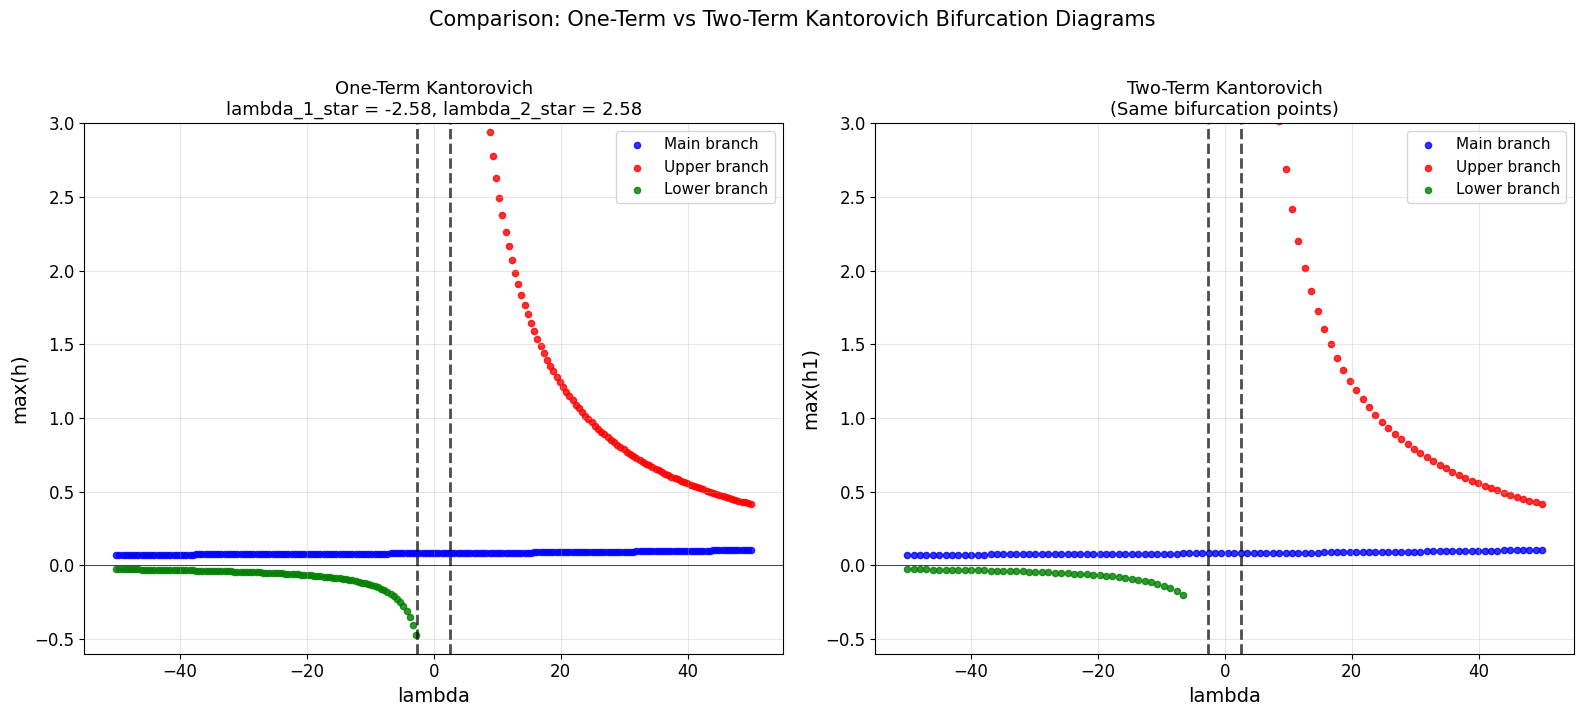

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: One-term
ax1 = axes[0]
lower_1t = h_max_scatter < -0.01
middle_1t = (h_max_scatter >= -0.01) & (h_max_scatter < 0.15)
upper_1t = h_max_scatter >= 0.15

ax1.scatter(lam_scatter[middle_1t], h_max_scatter[middle_1t],
            c='blue', s=20, alpha=0.8, label='Main branch')
ax1.scatter(lam_scatter[upper_1t], h_max_scatter[upper_1t],
            c='red', s=20, alpha=0.8, label='Upper branch')
ax1.scatter(lam_scatter[lower_1t], h_max_scatter[lower_1t],
            c='green', s=20, alpha=0.8, label='Lower branch')

ax1.axvline(x=lambda_1_star, color='black', linewidth=2, linestyle='--', alpha=0.7)
ax1.axvline(x=lambda_2_star, color='black', linewidth=2, linestyle='--', alpha=0.7)
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.set_xlabel('lambda', fontsize=14)
ax1.set_ylabel('max(h)', fontsize=14)
ax1.set_title(
    f'One-Term Kantorovich\nlambda_1_star = {lambda_1_star:.2f}, '
    f'lambda_2_star = {lambda_2_star:.2f}',
    fontsize=13
)
ax1.set_xlim(-55, 55)
ax1.set_ylim(-0.6, 3)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Right: Two-term
ax2 = axes[1]
lower_2t = h1_max_2t < -0.01
middle_2t = (h1_max_2t >= -0.01) & (h1_max_2t < 0.15)
upper_2t = h1_max_2t >= 0.15

ax2.scatter(lam_2t[middle_2t], h1_max_2t[middle_2t],
            c='blue', s=20, alpha=0.8, label='Main branch')
ax2.scatter(lam_2t[upper_2t], h1_max_2t[upper_2t],
            c='red', s=20, alpha=0.8, label='Upper branch')
ax2.scatter(lam_2t[lower_2t], h1_max_2t[lower_2t],
            c='green', s=20, alpha=0.8, label='Lower branch')

ax2.axvline(x=lambda_1_star, color='black', linewidth=2, linestyle='--', alpha=0.7)
ax2.axvline(x=lambda_2_star, color='black', linewidth=2, linestyle='--', alpha=0.7)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.set_xlabel('lambda', fontsize=14)
ax2.set_ylabel('max(h1)', fontsize=14)
ax2.set_title('Two-Term Kantorovich\n(Same bifurcation points)', fontsize=13)
ax2.set_xlim(-55, 55)
ax2.set_ylim(-0.6, 3)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.suptitle(
    'Comparison: One-Term vs Two-Term Kantorovich Bifurcation Diagrams',
    fontsize=15, y=1.02
)
plt.tight_layout()
plt.show()


## Some visualizations

### 1. 3D surface u(x,y)

In [87]:
def plot_3d_solution(h, title, ax, N=50):
    """Plot 3D surface u(x,y) = h(x) * sin(pi*y)"""
    x = np.linspace(0, 1, N + 2)
    y = np.linspace(0, 1, 101)
    X, Y = np.meshgrid(x, y)
    
    h_full = np.concatenate([[0], h, [0]])
    U = np.outer(np.sin(np.pi * y), h_full)
    
    surf = ax.plot_surface(X, Y, U, cmap='RdBu_r', edgecolor='none', alpha=0.9)
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_zlabel('u(x,y)', fontsize=11)
    ax.set_title(title, fontsize=12)
    return surf

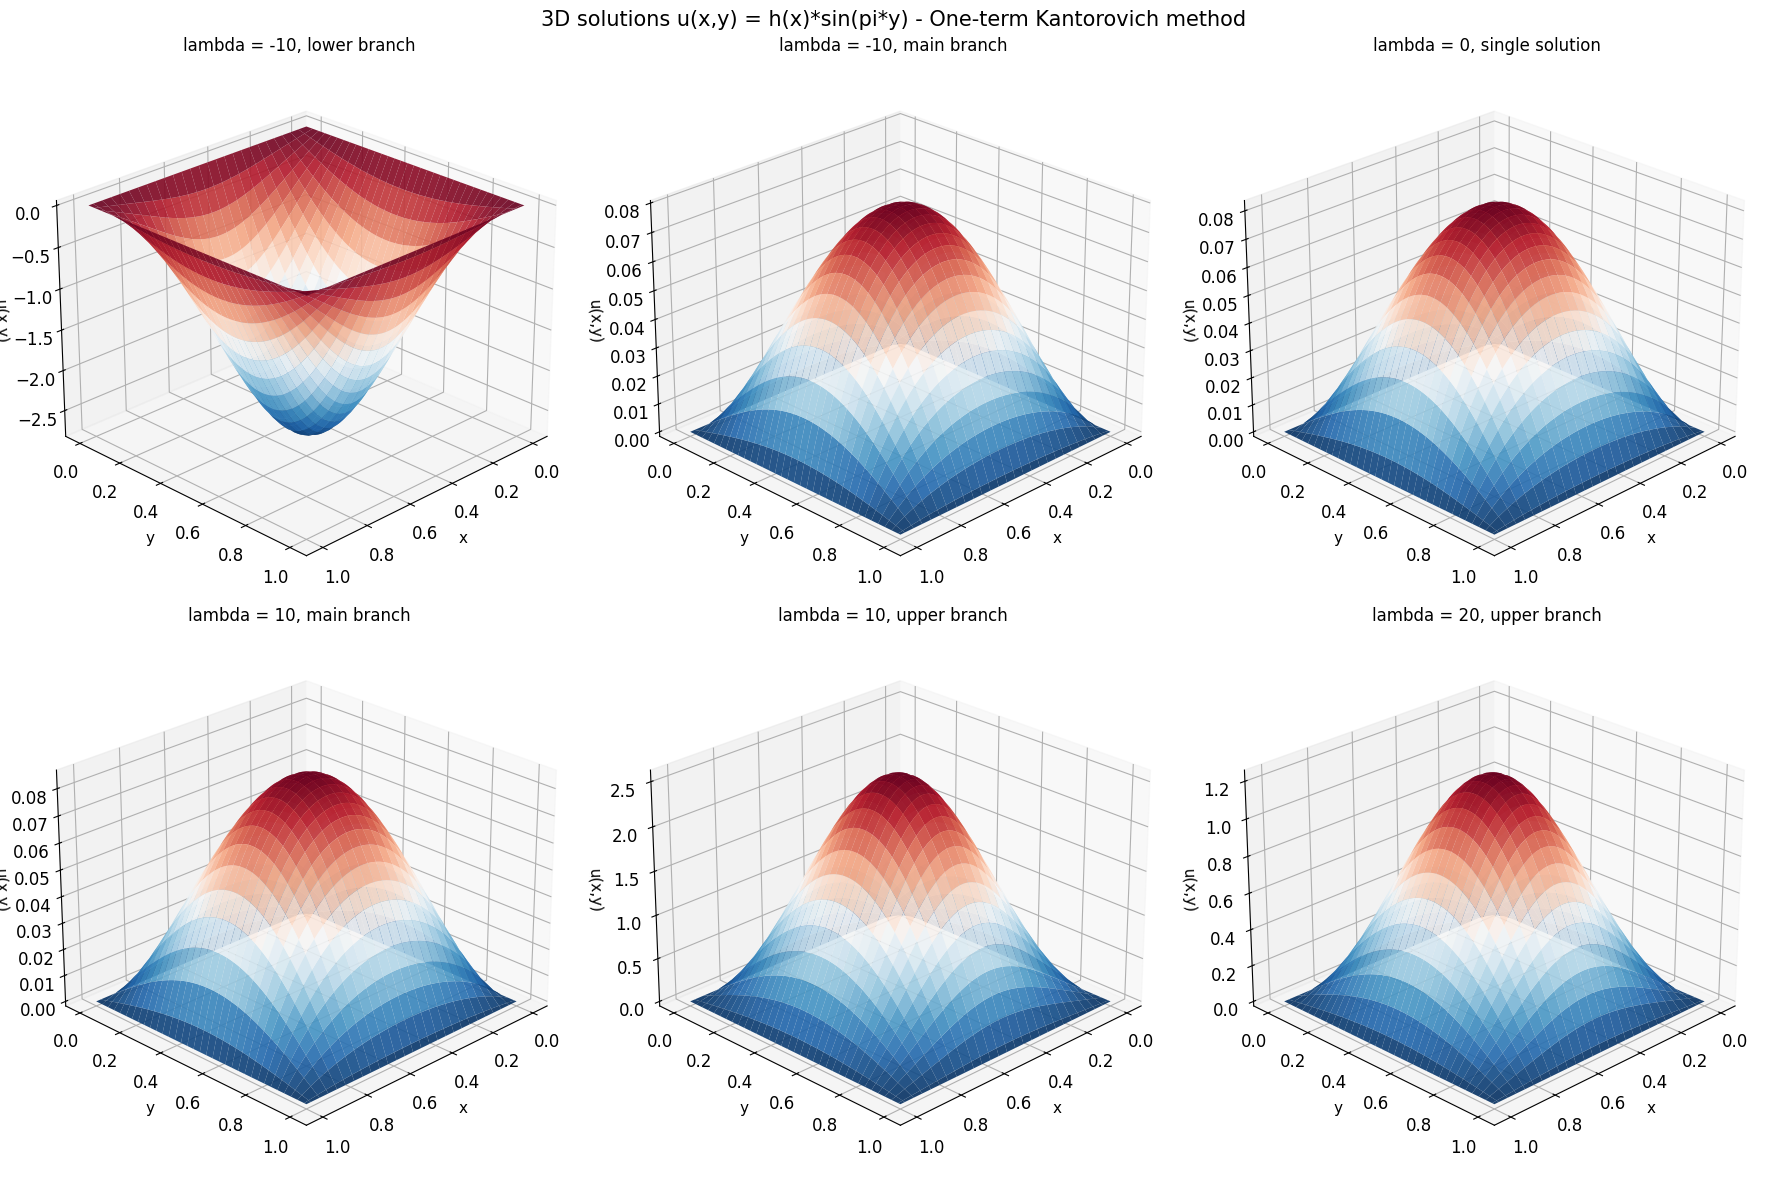

In [88]:
fig = plt.figure(figsize=(18, 12))
fig.suptitle('3D solutions u(x,y) = h(x)*sin(pi*y) - One-term Kantorovich method',
             fontsize=15, y=0.98)

# Get representative solutions
# lambda = -10
sols_neg10 = find_all_solutions_at_lambda(-10, N, dx, x_interior, num_trials=30)
sols_neg10_sorted = sorted(sols_neg10, key=lambda s: np.max(s))

# lambda = 0
sols_0 = find_all_solutions_at_lambda(0, N, dx, x_interior, num_trials=30)

# lambda = 10
sols_10 = find_all_solutions_at_lambda(10, N, dx, x_interior, num_trials=30)
sols_10_sorted = sorted(sols_10, key=lambda s: np.max(s))

# lambda = 20
sols_20 = find_all_solutions_at_lambda(20, N, dx, x_interior, num_trials=30)
sols_20_sorted = sorted(sols_20, key=lambda s: np.max(s))

plot_data = []
if len(sols_neg10_sorted) >= 2:
    plot_data.append((sols_neg10_sorted[0], 'lambda = -10, lower branch'))
    plot_data.append((sols_neg10_sorted[-1], 'lambda = -10, main branch'))
if len(sols_0) >= 1:
    plot_data.append((sols_0[0], 'lambda = 0, single solution'))
if len(sols_10_sorted) >= 2:
    plot_data.append((sols_10_sorted[0], 'lambda = 10, main branch'))
    plot_data.append((sols_10_sorted[-1], 'lambda = 10, upper branch'))
if len(sols_20_sorted) >= 1:
    plot_data.append((sols_20_sorted[-1], 'lambda = 20, upper branch'))

for i, (sol, title) in enumerate(plot_data[:6]):
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    surf = plot_3d_solution(sol, title, ax, N)
    ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

In [89]:
# (Since h2 == 0, these surfaces are identical to the one-term case, but we verify this)
def plot_3d_solution_2term(h1, h2, title, ax, N=50):
    """Plot 3D surface u(x,y) = h1(x)*sin(pi*y) + h2(x)*sin(2*pi*y)"""
    x = np.linspace(0, 1, N + 2)
    y = np.linspace(0, 1, 101)
    X, Y = np.meshgrid(x, y)
    
    h1_full = np.concatenate([[0], h1, [0]])
    h2_full = np.concatenate([[0], h2, [0]])
    
    U = np.outer(np.sin(np.pi * y), h1_full) + np.outer(np.sin(2*np.pi * y), h2_full)
    
    surf = ax.plot_surface(X, Y, U, cmap='RdBu_r', edgecolor='none', alpha=0.9)
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_zlabel('u(x,y)', fontsize=11)
    ax.set_title(title, fontsize=12)
    return surf

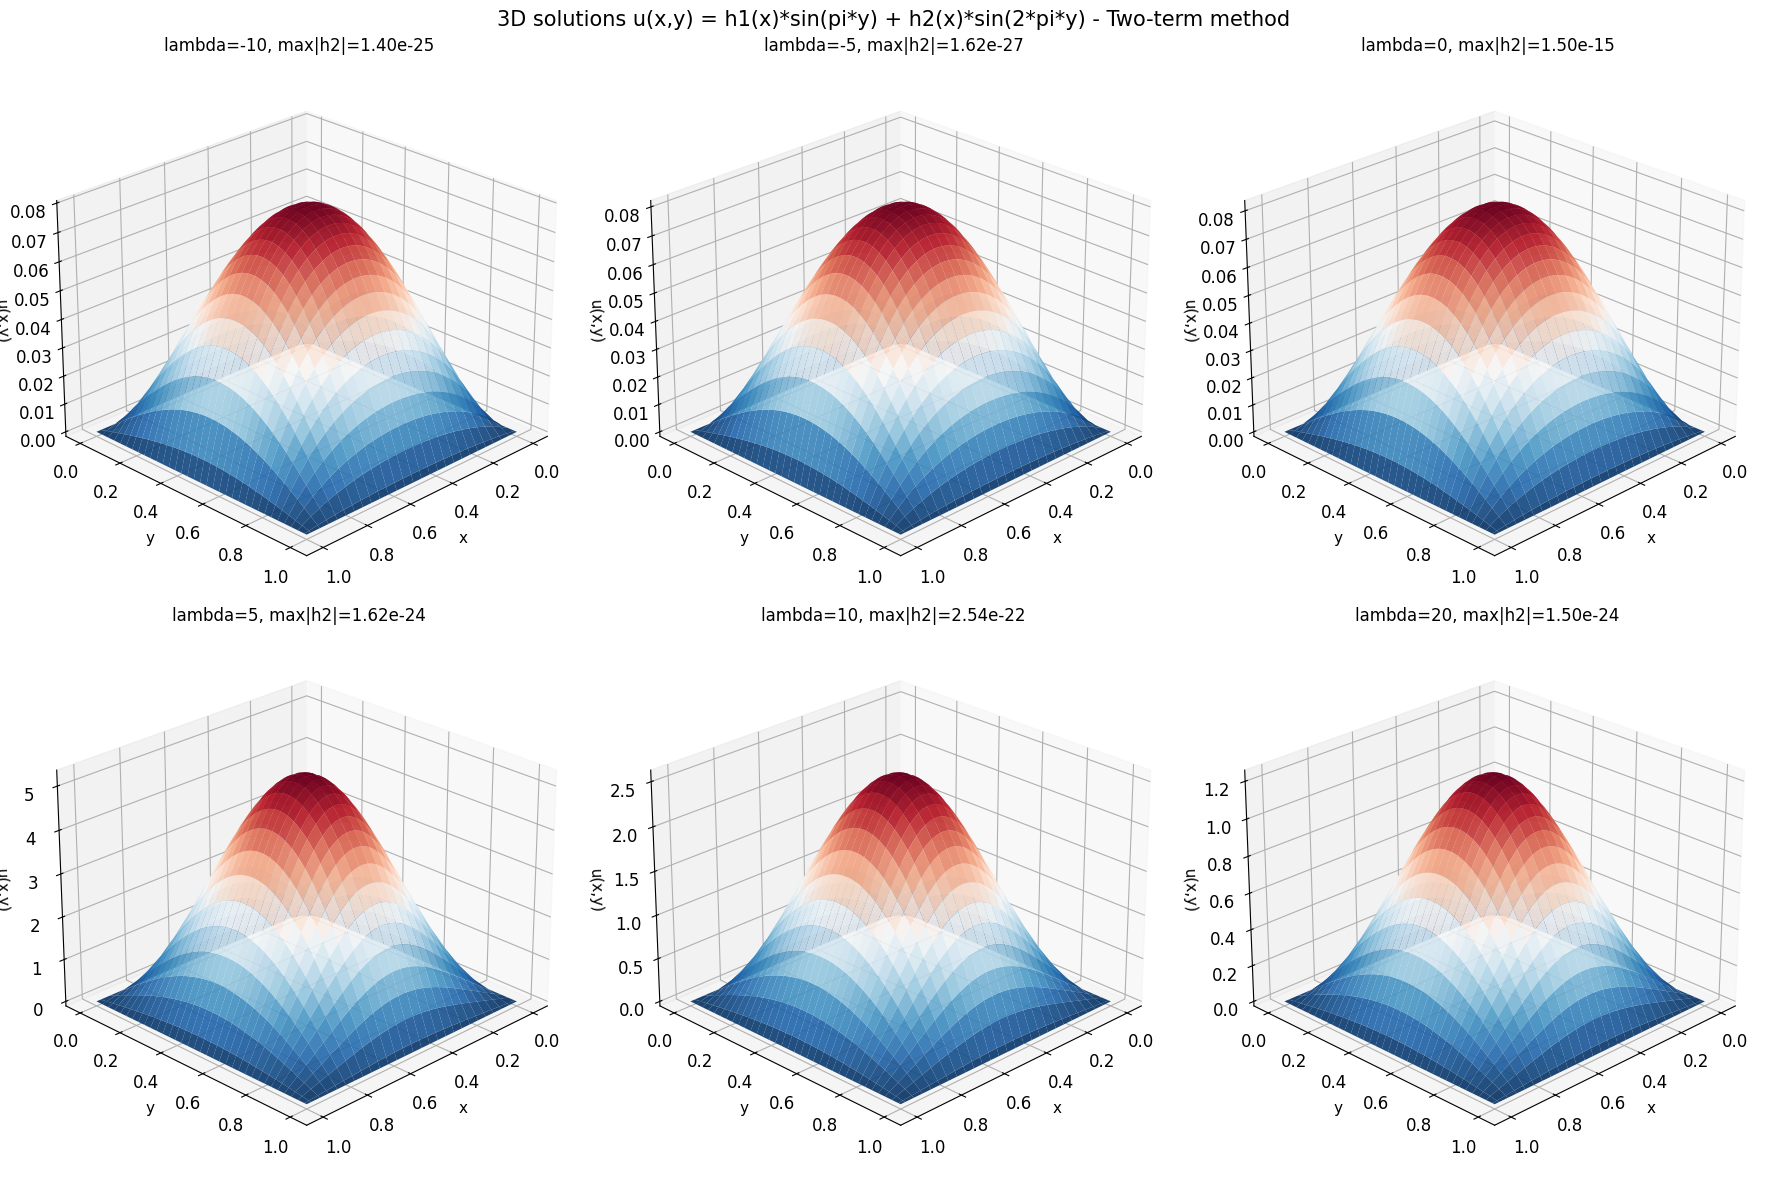

In [90]:
# Obtain two-term solutions
fig = plt.figure(figsize=(18, 12))
fig.suptitle(
    '3D solutions u(x,y) = h1(x)*sin(pi*y) + h2(x)*sin(2*pi*y) - Two-term method',
    fontsize=15, y=0.98
)

test_lambdas_2t = [-10, -5, 0, 5, 10, 20]
plot_idx = 1

for lam_val in test_lambdas_2t:
    sols = find_all_solutions_2term(
        lam_val, N_2term, dx_2term, x_interior_2term, num_trials=25
    )
    if len(sols) > 0:
        # Take the solution with the largest h1
        sol = max(sols, key=lambda s: np.max(s[:N_2term]))
        h1 = sol[:N_2term]
        h2 = sol[N_2term:]
        
        ax = fig.add_subplot(2, 3, plot_idx, projection='3d')
        plot_3d_solution_2term(
            h1, h2,
            f'lambda={lam_val}, max|h2|={np.max(np.abs(h2)):.2e}',
            ax, N_2term
        )
        ax.view_init(elev=25, azim=45)
        plot_idx += 1
        
        if plot_idx > 6:
            break

plt.tight_layout()
plt.show()

### 2. Profiles of h(x) for different lambda values

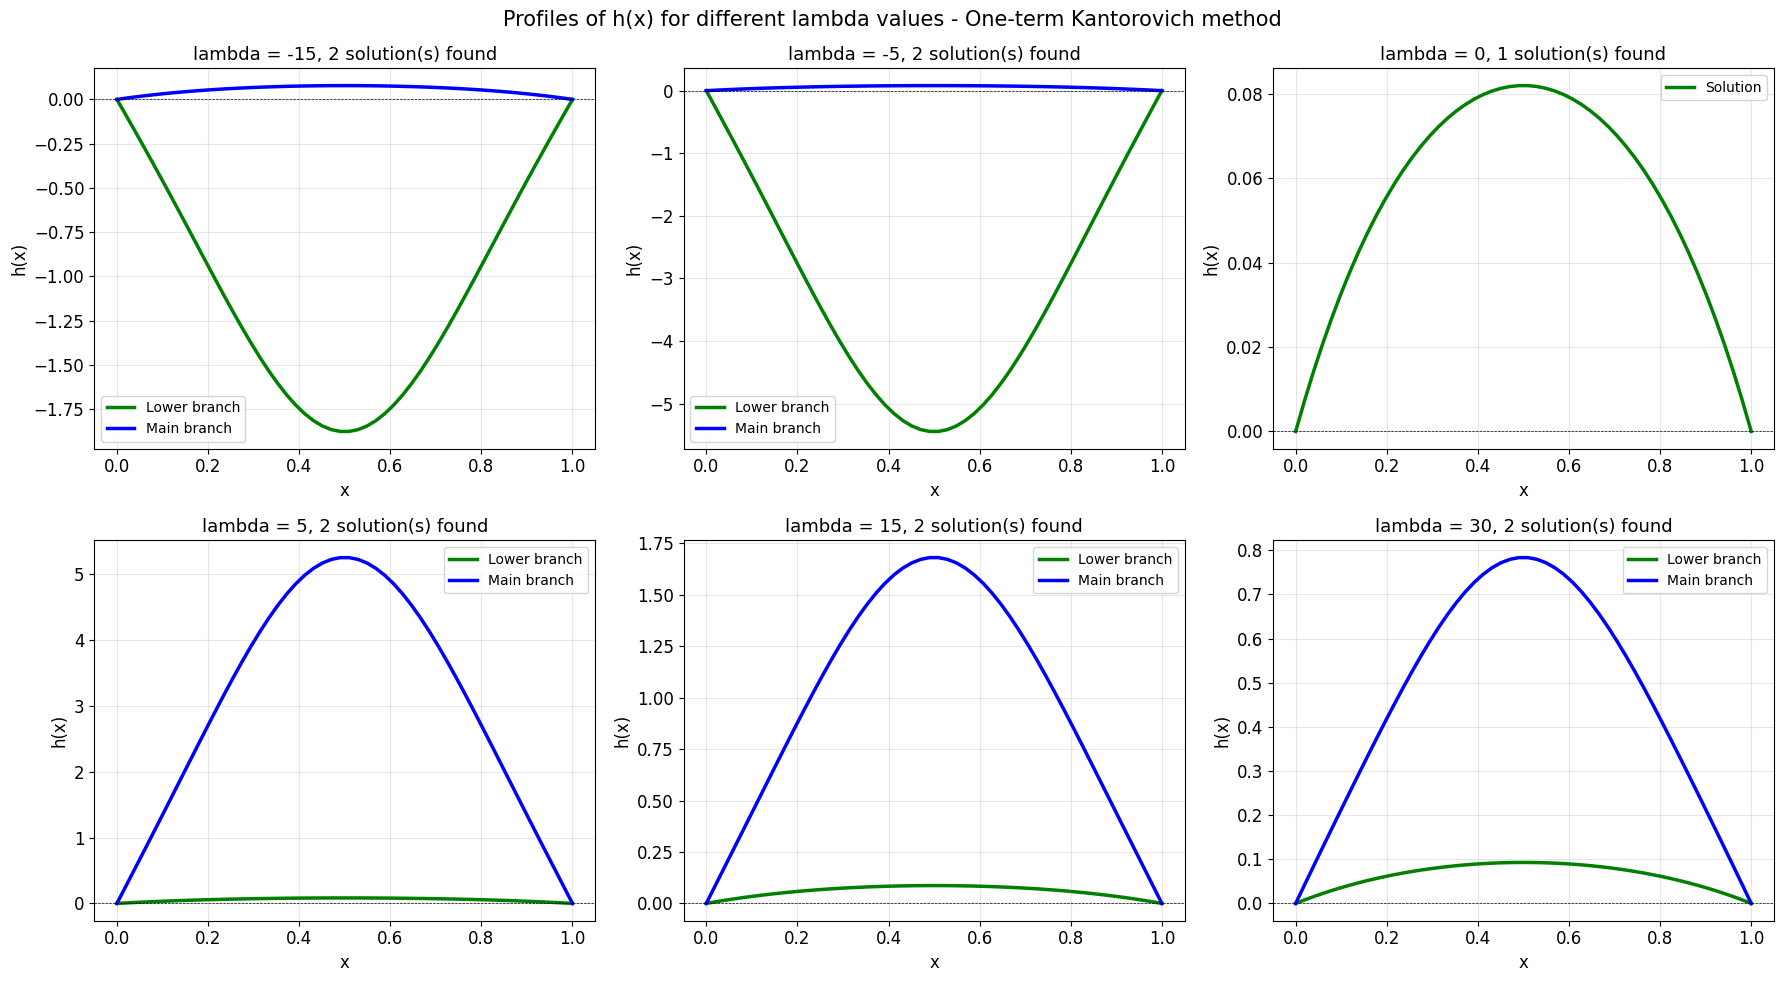

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Profiles of h(x) for different lambda values - One-term Kantorovich method',
             fontsize=15, y=0.98)

x_plot = np.linspace(0, 1, N + 2)
test_lambdas = [-15, -5, 0, 5, 15, 30]

for idx, lam_val in enumerate(test_lambdas):
    ax = axes[idx // 3, idx % 3]
    
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=40)
    sols_sorted = sorted(sols, key=lambda s: np.max(s))
    
    colors = ['green', 'blue', 'red']
    labels = ['Lower branch', 'Main branch', 'Upper branch']
    
    for i, sol in enumerate(sols_sorted):
        h_full = np.concatenate([[0], sol, [0]])
        color = colors[min(i, 2)]
        label = labels[min(i, 2)] if len(sols_sorted) > 1 else 'Solution'
        ax.plot(x_plot, h_full, color=color, linewidth=2.5, label=label)
    
    ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('h(x)', fontsize=12)
    ax.set_title(f'lambda = {lam_val}, {len(sols_sorted)} solution(s) found', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


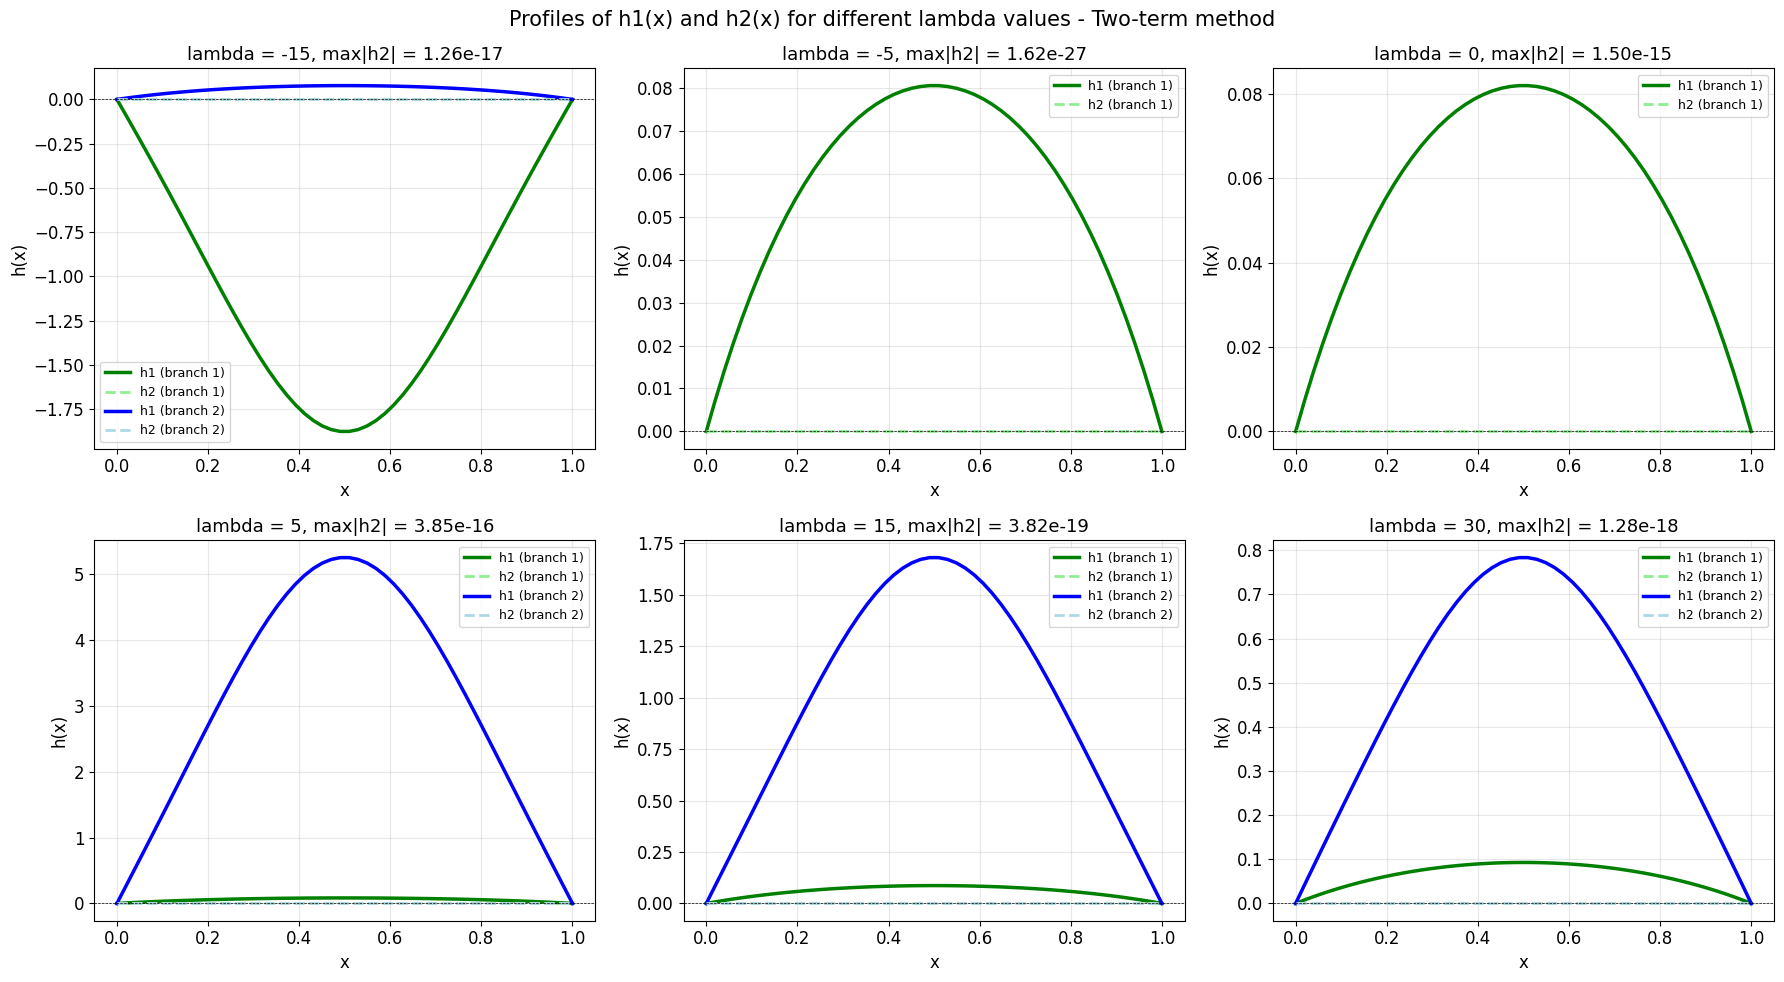

Profiles of h1(x) and h2(x) for the two-term method have been constructed.
Confirmation: h2(x) approx 0 for all solutions (dashed lines lie on the axis).


In [92]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Profiles of h1(x) and h2(x) for different lambda values - Two-term method',
             fontsize=15, y=0.98)

x_plot_2t = np.linspace(0, 1, N_2term + 2)
test_lambdas_2t = [-15, -5, 0, 5, 15, 30]

for idx, lam_val in enumerate(test_lambdas_2t):
    ax = axes[idx // 3, idx % 3]
    
    sols = find_all_solutions_2term(
        lam_val, N_2term, dx_2term, x_interior_2term, num_trials=30
    )
    
    if len(sols) == 0:
        ax.text(0.5, 0.5, 'No solution found',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'lambda = {lam_val}')
        continue
    
    sols_sorted = sorted(sols, key=lambda s: np.max(s[:N_2term]))
    
    colors_h1 = ['green', 'blue', 'red']
    colors_h2 = ['lightgreen', 'lightblue', 'salmon']
    
    for i, sol in enumerate(sols_sorted):
        h1 = sol[:N_2term]
        h2 = sol[N_2term:]
        h1_full = np.concatenate([[0], h1, [0]])
        h2_full = np.concatenate([[0], h2, [0]])
        
        color1 = colors_h1[min(i, 2)]
        color2 = colors_h2[min(i, 2)]
        
        label1 = f'h1 (branch {i+1})' if i < 3 else None
        label2 = f'h2 (branch {i+1})' if i < 3 else None
        
        ax.plot(x_plot_2t, h1_full, color=color1,
                linewidth=2.5, linestyle='-', label=label1)
        ax.plot(x_plot_2t, h2_full, color=color2,
                linewidth=2, linestyle='--', label=label2)
    
    ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('h(x)', fontsize=12)
    
    max_h2 = max([np.max(np.abs(s[N_2term:])) for s in sols_sorted])
    ax.set_title(f'lambda = {lam_val}, max|h2| = {max_h2:.2e}', fontsize=13)
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Profiles of h1(x) and h2(x) for the two-term method have been constructed.')
print('Confirmation: h2(x) approx 0 for all solutions (dashed lines lie on the axis).')

### 3. Phase portraits h, h_prime for different solutions

In [93]:
def compute_derivative(h, dx):
    """Compute h'(x) using central differences"""
    h_full = np.concatenate([[0], h, [0]])
    h_prime = np.zeros(len(h))
    for i in range(len(h)):
        h_prime[i] = (h_full[i+2] - h_full[i]) / (2*dx)
    return h_prime

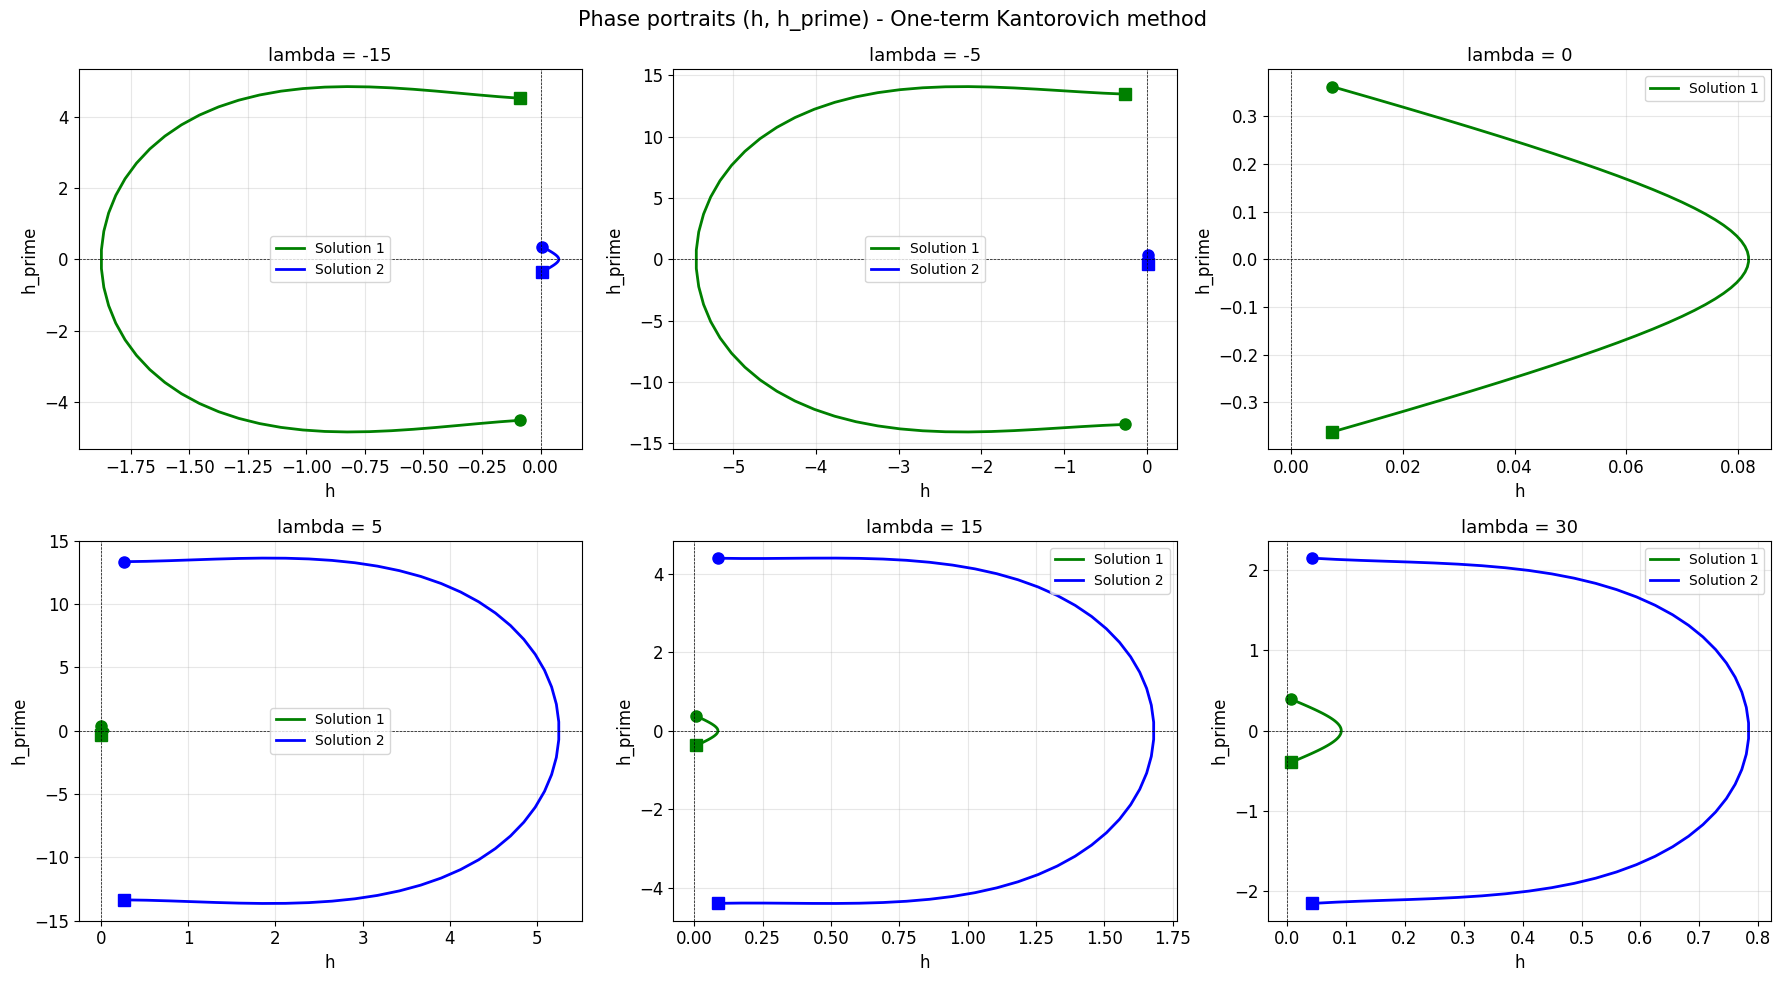

Phase portraits for the one-term method have been constructed.
o - start of the trajectory (x = 0), s - end of the trajectory (x = 1)


In [94]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Phase portraits (h, h_prime) - One-term Kantorovich method',
             fontsize=15, y=0.98)

test_lambdas_phase = [-15, -5, 0, 5, 15, 30]

for idx, lam_val in enumerate(test_lambdas_phase):
    ax = axes[idx // 3, idx % 3]
    
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=40)
    sols_sorted = sorted(sols, key=lambda s: np.max(s))
    
    colors = ['green', 'blue', 'red', 'purple', 'orange']
    
    for i, sol in enumerate(sols_sorted):
        h_prime = compute_derivative(sol, dx)
        color = colors[i % len(colors)]
        ax.plot(sol, h_prime, color=color, linewidth=2,
                label=f'Solution {i+1}')
        # Mark start and end points
        ax.plot(sol[0], h_prime[0], 'o', color=color, markersize=8)
        ax.plot(sol[-1], h_prime[-1], 's', color=color, markersize=8)
    
    ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--')
    ax.set_xlabel('h', fontsize=12)
    ax.set_ylabel('h_prime', fontsize=12)
    ax.set_title(f'lambda = {lam_val}', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Phase portraits for the one-term method have been constructed.")
print("o - start of the trajectory (x = 0), s - end of the trajectory (x = 1)")

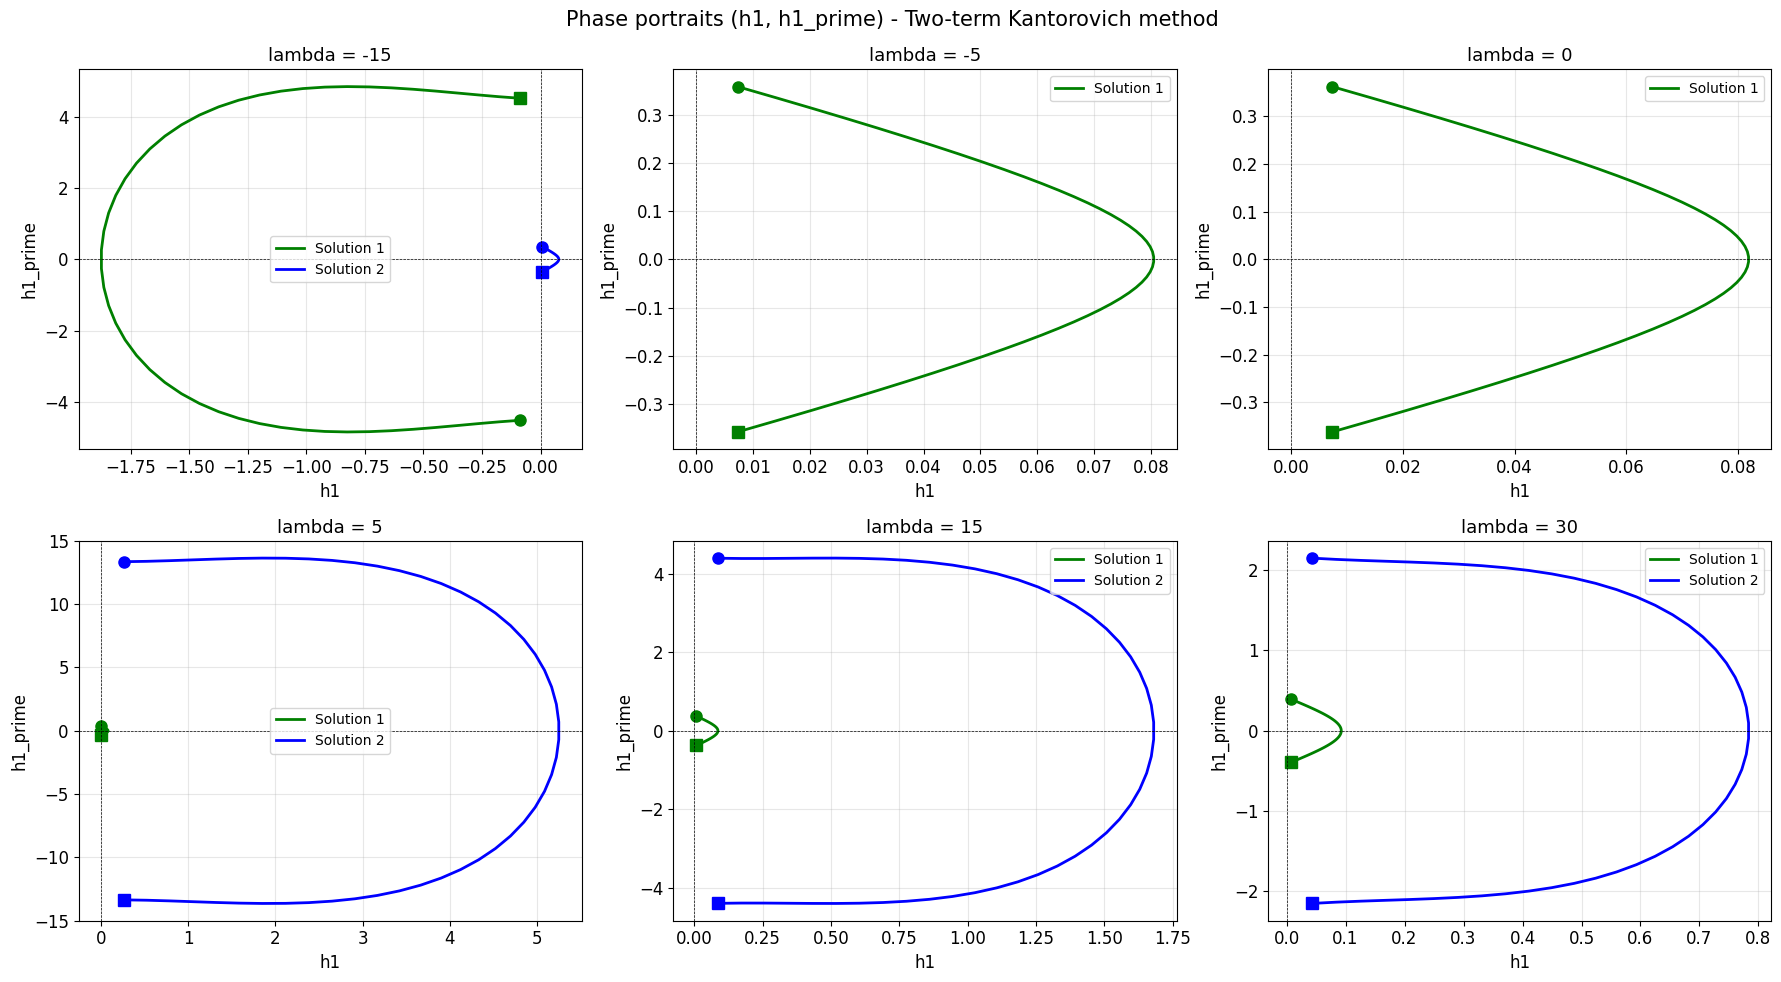

In [95]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Phase portraits (h1, h1_prime) - Two-term Kantorovich method',
             fontsize=15, y=0.98)

for idx, lam_val in enumerate(test_lambdas_phase):
    ax = axes[idx // 3, idx % 3]
    
    sols = find_all_solutions_2term(
        lam_val, N_2term, dx_2term, x_interior_2term, num_trials=30
    )
    
    if len(sols) == 0:
        ax.text(0.5, 0.5, 'No solution found',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'lambda = {lam_val}')
        continue
    
    sols_sorted = sorted(sols, key=lambda s: np.max(s[:N_2term]))
    
    colors = ['green', 'blue', 'red', 'purple', 'orange']
    
    for i, sol in enumerate(sols_sorted):
        h1 = sol[:N_2term]
        h1_prime = compute_derivative(h1, dx_2term)
        color = colors[i % len(colors)]
        ax.plot(h1, h1_prime, color=color, linewidth=2,
                label=f'Solution {i+1}')
        ax.plot(h1[0], h1_prime[0], 'o', color=color, markersize=8)
        ax.plot(h1[-1], h1_prime[-1], 's', color=color, markersize=8)
    
    ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(x=0, color='k', linewidth=0.5, linestyle='--')
    ax.set_xlabel('h1', fontsize=12)
    ax.set_ylabel('h1_prime', fontsize=12)
    ax.set_title(f'lambda = {lam_val}', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4. Evolution of h(x) as lambda varies

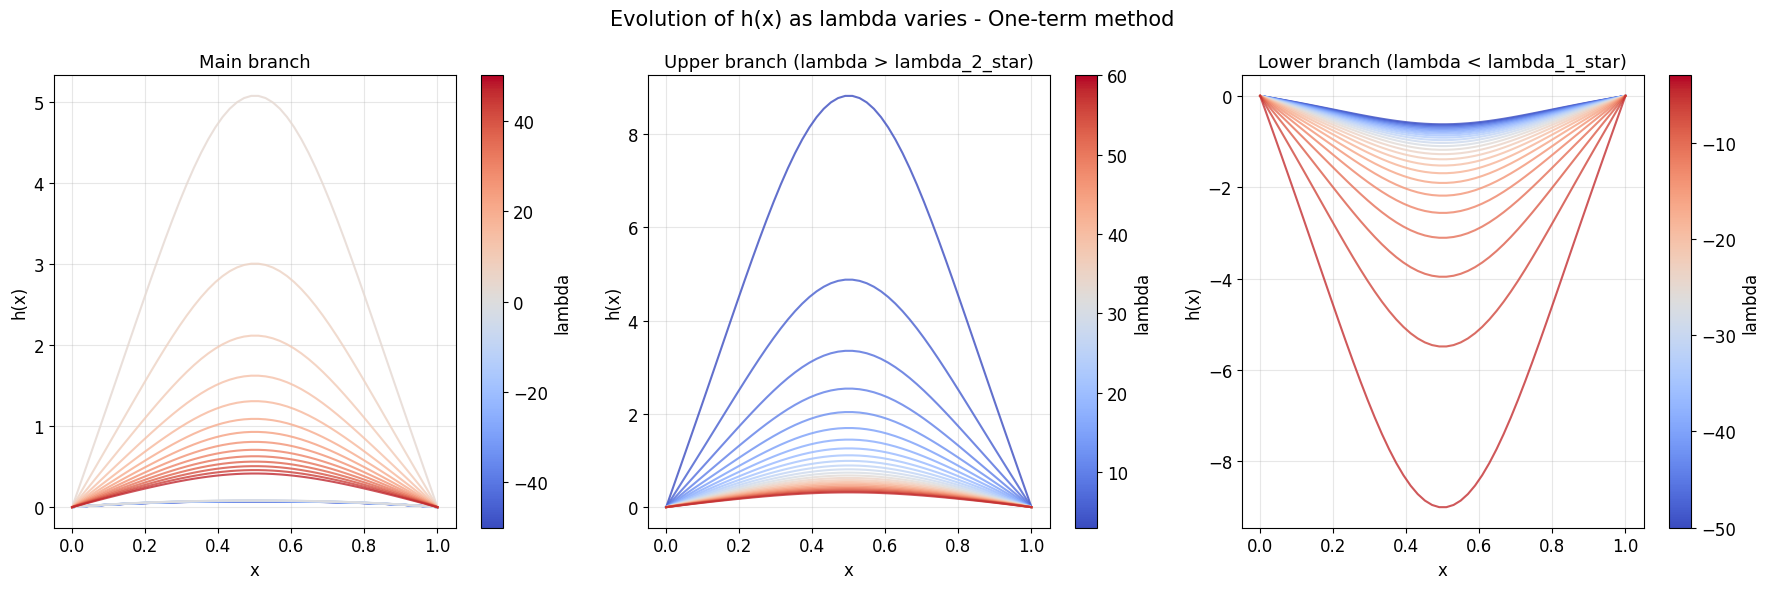

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Evolution of h(x) as lambda varies - One-term method', fontsize=15, y=0.98)

x_plot = np.linspace(0, 1, N + 2)

# Main branch evolution
ax1 = axes[0]
lambda_range_main = np.linspace(-50, 50, 30)
cmap = plt.cm.coolwarm

for i, lam_val in enumerate(lambda_range_main):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=20)
    if len(sols) > 0:
        # Find middle solution (main branch)
        sols_sorted = sorted(sols, key=lambda s: np.max(s))
        if len(sols_sorted) >= 2:
            sol = sols_sorted[len(sols_sorted)//2]  # middle
        else:
            sol = sols_sorted[0]
        h_full = np.concatenate([[0], sol, [0]])
        color = cmap(i / len(lambda_range_main))
        ax1.plot(x_plot, h_full, color=color, linewidth=1.5, alpha=0.8)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-50, 50))
sm.set_array([])
plt.colorbar(sm, ax=ax1, label='lambda')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('h(x)', fontsize=12)
ax1.set_title('Main branch', fontsize=13)
ax1.grid(True, alpha=0.3)

# Upper branch evolution (lambda > lambda_2_star)
ax2 = axes[1]
lambda_range_upper = np.linspace(3, 60, 25)

for i, lam_val in enumerate(lambda_range_upper):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=20)
    if len(sols) >= 2:
        sol = max(sols, key=lambda s: np.max(s))  # upper branch
        h_full = np.concatenate([[0], sol, [0]])
        color = cmap(i / len(lambda_range_upper))
        ax2.plot(x_plot, h_full, color=color, linewidth=1.5, alpha=0.8)

sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(3, 60))
sm2.set_array([])
plt.colorbar(sm2, ax=ax2, label='lambda')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('h(x)', fontsize=12)
ax2.set_title('Upper branch (lambda > lambda_2_star)', fontsize=13)
ax2.grid(True, alpha=0.3)

# Lower branch evolution (lambda < lambda_1_star)
ax3 = axes[2]
lambda_range_lower = np.linspace(-50, -3, 25)

for i, lam_val in enumerate(lambda_range_lower):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=20)
    if len(sols) >= 2:
        sol = min(sols, key=lambda s: np.max(s))  # lower branch
        h_full = np.concatenate([[0], sol, [0]])
        color = cmap(i / len(lambda_range_lower))
        ax3.plot(x_plot, h_full, color=color, linewidth=1.5, alpha=0.8)

sm3 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-50, -3))
sm3.set_array([])
plt.colorbar(sm3, ax=ax3, label='lambda')
ax3.set_xlabel('x', fontsize=12)
ax3.set_ylabel('h(x)', fontsize=12)
ax3.set_title('Lower branch (lambda < lambda_1_star)', fontsize=13)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

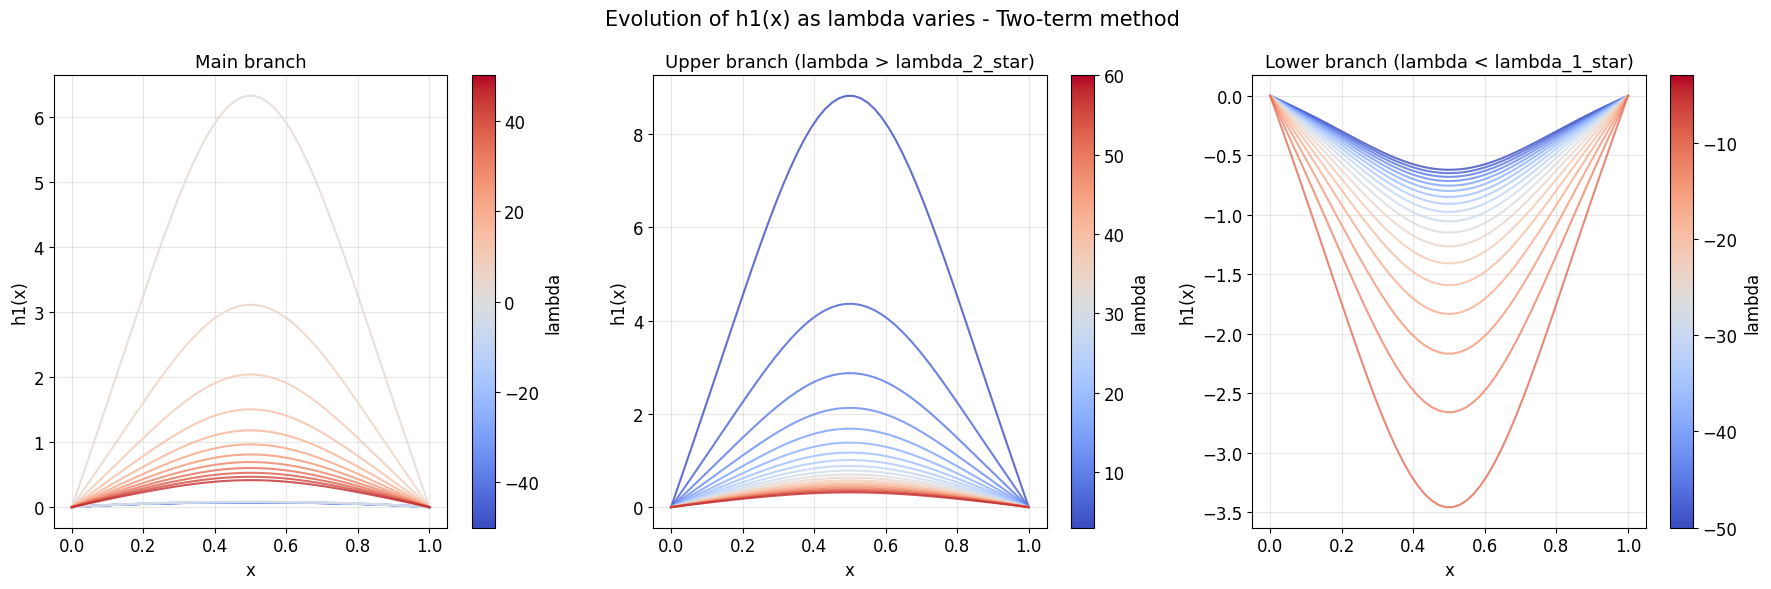

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Evolution of h1(x) as lambda varies - Two-term method', fontsize=15, y=0.98)

x_plot_2t = np.linspace(0, 1, N_2term + 2)

# Main branch
ax1 = axes[0]
lambda_range_main_2t = np.linspace(-50, 50, 25)

for i, lam_val in enumerate(lambda_range_main_2t):
    sols = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=15)
    if len(sols) > 0:
        sols_sorted = sorted(sols, key=lambda s: np.max(s[:N_2term]))
        if len(sols_sorted) >= 2:
            sol = sols_sorted[len(sols_sorted)//2]
        else:
            sol = sols_sorted[0]
        h1 = sol[:N_2term]
        h1_full = np.concatenate([[0], h1, [0]])
        color = cmap(i / len(lambda_range_main_2t))
        ax1.plot(x_plot_2t, h1_full, color=color, linewidth=1.5, alpha=0.8)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-50, 50))
sm.set_array([])
plt.colorbar(sm, ax=ax1, label='lambda')
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('h1(x)', fontsize=12)
ax1.set_title('Main branch', fontsize=13)
ax1.grid(True, alpha=0.3)

# Upper branch
ax2 = axes[1]
lambda_range_upper_2t = np.linspace(3, 60, 20)

for i, lam_val in enumerate(lambda_range_upper_2t):
    sols = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=15)
    if len(sols) >= 2:
        sol = max(sols, key=lambda s: np.max(s[:N_2term]))
        h1 = sol[:N_2term]
        h1_full = np.concatenate([[0], h1, [0]])
        color = cmap(i / len(lambda_range_upper_2t))
        ax2.plot(x_plot_2t, h1_full, color=color, linewidth=1.5, alpha=0.8)

sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(3, 60))
sm2.set_array([])
plt.colorbar(sm2, ax=ax2, label='lambda')
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('h1(x)', fontsize=12)
ax2.set_title('Upper branch (lambda > lambda_2_star)', fontsize=13)
ax2.grid(True, alpha=0.3)

# Lower branch
ax3 = axes[2]
lambda_range_lower_2t = np.linspace(-50, -3, 20)

for i, lam_val in enumerate(lambda_range_lower_2t):
    sols = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=15)
    if len(sols) >= 2:
        sol = min(sols, key=lambda s: np.max(s[:N_2term]))
        h1 = sol[:N_2term]
        h1_full = np.concatenate([[0], h1, [0]])
        color = cmap(i / len(lambda_range_lower_2t))
        ax3.plot(x_plot_2t, h1_full, color=color, linewidth=1.5, alpha=0.8)

sm3 = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-50, -3))
sm3.set_array([])
plt.colorbar(sm3, ax=ax3, label='lambda')
ax3.set_xlabel('x', fontsize=12)
ax3.set_ylabel('h1(x)', fontsize=12)
ax3.set_title('Lower branch (lambda < lambda_1_star)', fontsize=13)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 5. Cross-sections of the 2D-solution u(x,y)

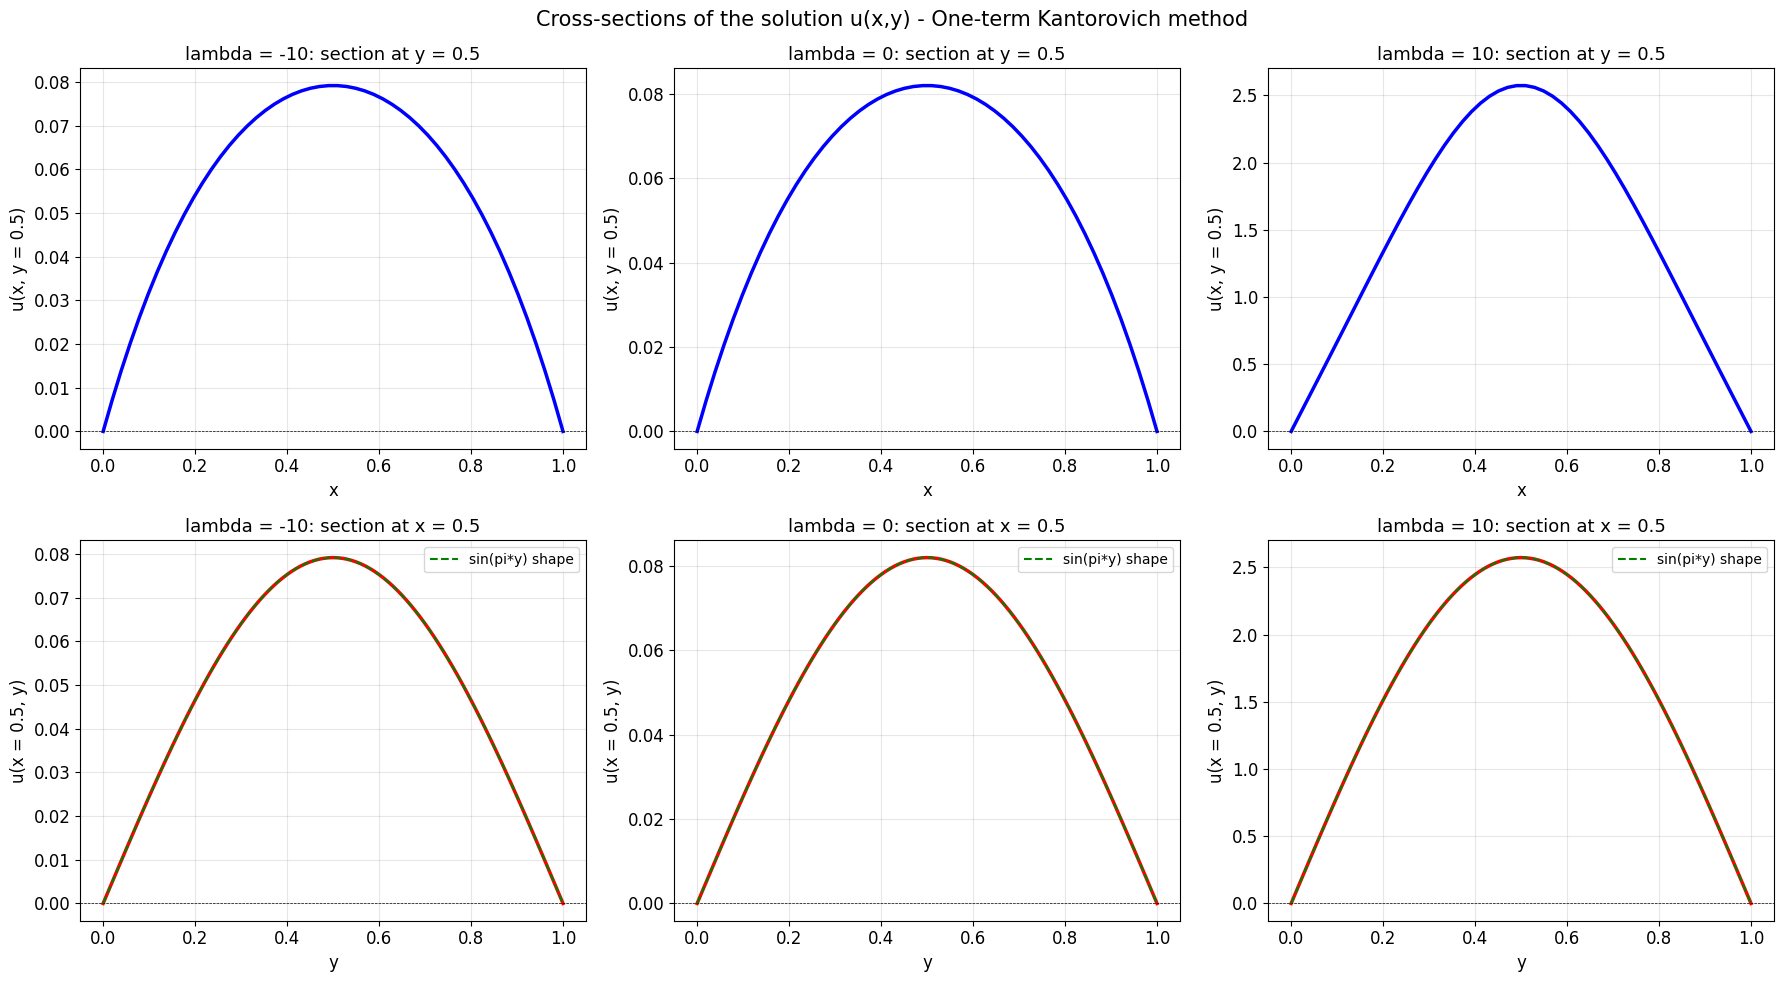

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Cross-sections of the solution u(x,y) - One-term Kantorovich method',
             fontsize=15, y=0.98)

test_lambdas_section = [-10, 0, 10]

for col, lam_val in enumerate(test_lambdas_section):
    sols = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=30)
    
    if len(sols) == 0:
        continue
    
    # Take the solution with the largest max(h)
    sol = max(sols, key=lambda s: np.max(s))
    h_full = np.concatenate([[0], sol, [0]])
    
    x = np.linspace(0, 1, N + 2)
    y = np.linspace(0, 1, 101)
    
    # u(x,y) = h(x) * sin(pi*y)
    U = np.outer(np.sin(np.pi * y), h_full)
    
    # Top row: u(x, y = 0.5) - section along x at y = 0.5
    ax1 = axes[0, col]
    y_idx = 50  # y = 0.5
    u_section_x = U[y_idx, :]
    ax1.plot(x, u_section_x, 'b-', linewidth=2.5)
    ax1.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('u(x, y = 0.5)', fontsize=12)
    ax1.set_title(f'lambda = {lam_val}: section at y = 0.5', fontsize=13)
    ax1.grid(True, alpha=0.3)
    
    # Bottom row: u(x = 0.5, y) - section along y at x = 0.5
    ax2 = axes[1, col]
    x_idx = (N + 2) // 2  # x = 0.5
    u_section_y = U[:, x_idx]
    ax2.plot(y, u_section_y, 'r-', linewidth=2.5)
    ax2.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax2.set_xlabel('y', fontsize=12)
    ax2.set_ylabel('u(x = 0.5, y)', fontsize=12)
    ax2.set_title(f'lambda = {lam_val}: section at x = 0.5', fontsize=13)
    ax2.grid(True, alpha=0.3)
    
    # Add theoretical sin(pi*y) shape for comparison
    theoretical_shape = np.max(u_section_y) * np.sin(np.pi * y)
    ax2.plot(y, theoretical_shape, 'g--', linewidth=1.5,
             label='sin(pi*y) shape')
    ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()


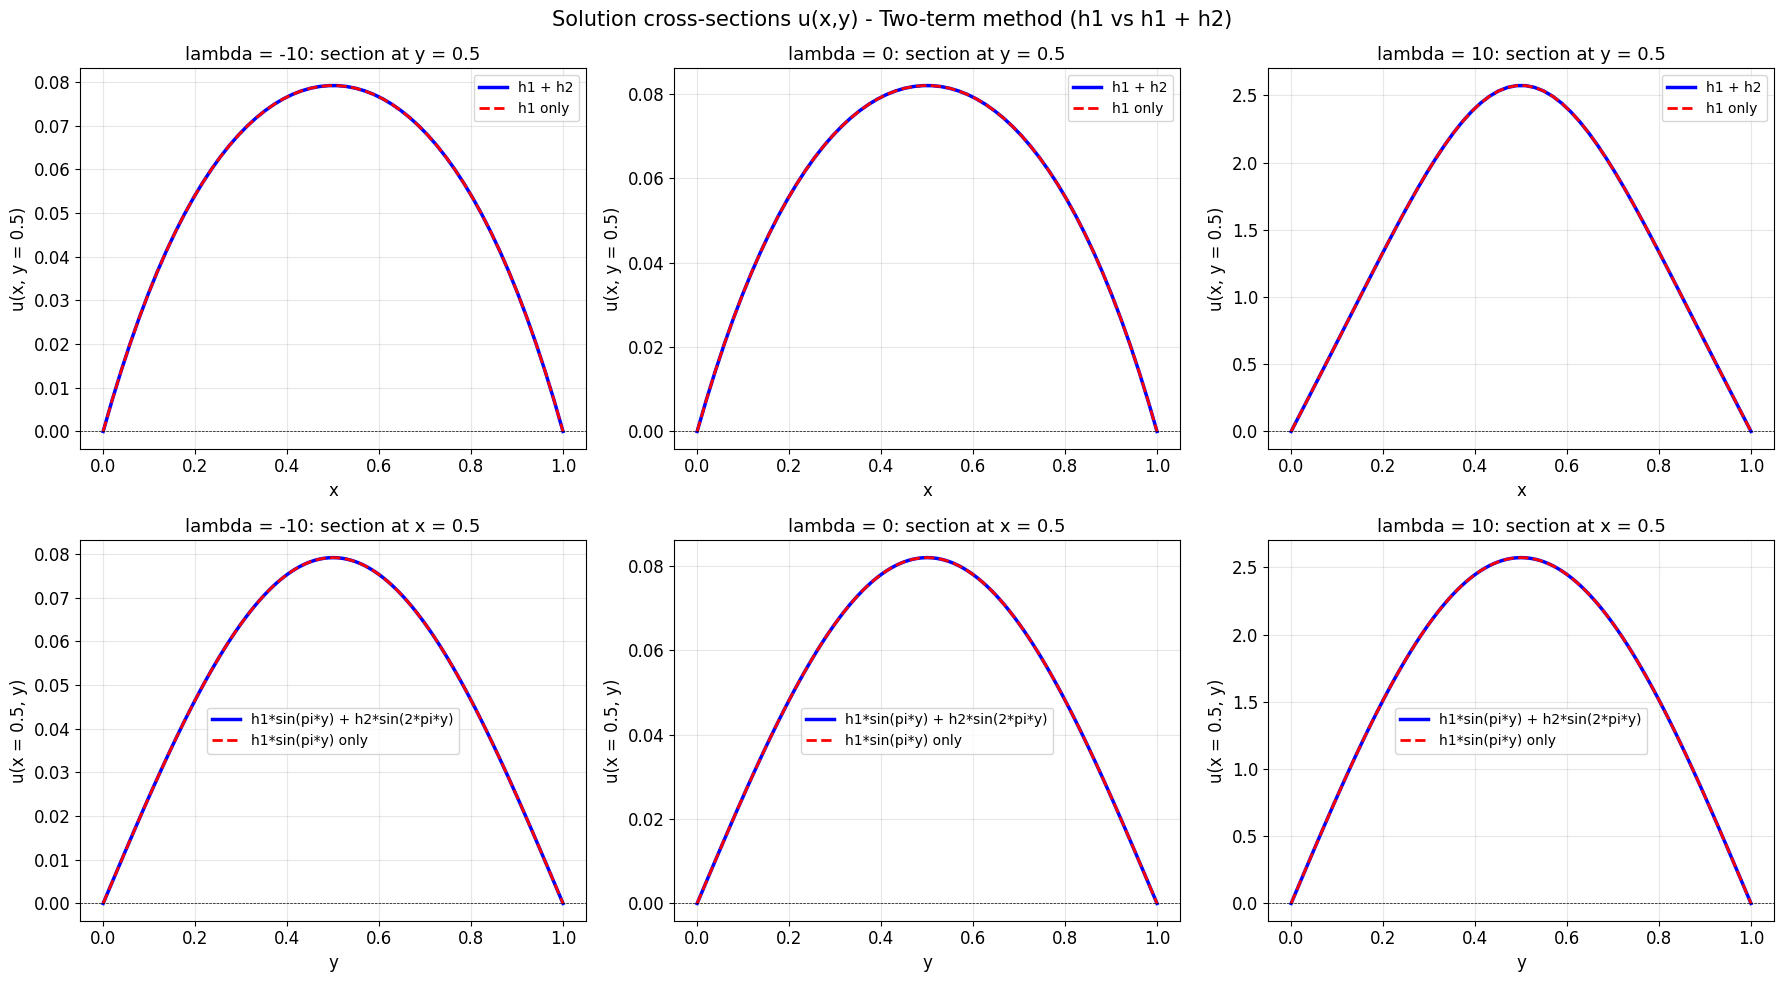

In [99]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Solution cross-sections u(x,y) - Two-term method (h1 vs h1 + h2)', fontsize=15, y=0.98)

for col, lam_val in enumerate(test_lambdas_section):
    sols = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=25)
    
    if len(sols) == 0:
        continue
    
    sol = max(sols, key=lambda s: np.max(s[:N_2term]))
    h1 = sol[:N_2term]
    h2 = sol[N_2term:]
    
    h1_full = np.concatenate([[0], h1, [0]])
    h2_full = np.concatenate([[0], h2, [0]])
    
    x = np.linspace(0, 1, N_2term + 2)
    y = np.linspace(0, 1, 101)
    
    # Full solution: u = h1*sin(pi*y) + h2*sin(2*pi*y)
    U_full = np.outer(np.sin(np.pi * y), h1_full) + np.outer(np.sin(2*np.pi * y), h2_full)
    U_h1_only = np.outer(np.sin(np.pi * y), h1_full)
    
    # Top row: section at y = 0.5
    ax1 = axes[0, col]
    y_idx = 50
    ax1.plot(x, U_full[y_idx, :], 'b-', linewidth=2.5, label='h1 + h2')
    ax1.plot(x, U_h1_only[y_idx, :], 'r--', linewidth=2, label='h1 only')
    ax1.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('u(x, y = 0.5)', fontsize=12)
    ax1.set_title(f'lambda = {lam_val}: section at y = 0.5', fontsize=13)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Bottom row: section at x = 0.5
    ax2 = axes[1, col]
    x_idx = (N_2term + 2) // 2
    ax2.plot(y, U_full[:, x_idx], 'b-', linewidth=2.5, label='h1*sin(pi*y) + h2*sin(2*pi*y)')
    ax2.plot(y, U_h1_only[:, x_idx], 'r--', linewidth=2, label='h1*sin(pi*y) only')
    ax2.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
    ax2.set_xlabel('y', fontsize=12)
    ax2.set_ylabel('u(x = 0.5, y)', fontsize=12)
    ax2.set_title(f'lambda = {lam_val}: section at x = 0.5', fontsize=13)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 6. Summary table: comparison of max(h) for all branches

In [100]:
import pandas as pd


In [101]:
test_lambdas_table = [-20, -10, -5, 0, 5, 10, 20, 30]

table_data = []

for lam_val in test_lambdas_table:
    # One-term
    sols_1t = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=30)
    n_sols_1t = len(sols_1t)

    if n_sols_1t > 0:
        max_vals_1t = sorted([np.max(s) for s in sols_1t])
        max_str_1t = ", ".join([f"{v:.4f}" for v in max_vals_1t])
    else:
        max_str_1t = "N/A"

    # Two-term
    sols_2t = find_all_solutions_2term(
        lam_val, N_2term, dx_2term, x_interior_2term, num_trials=25
    )
    n_sols_2t = len(sols_2t)

    if n_sols_2t > 0:
        max_vals_2t = sorted([np.max(s[:N_2term]) for s in sols_2t])
        max_str_2t = ", ".join([f"{v:.4f}" for v in max_vals_2t])
        max_h2 = max([np.max(np.abs(s[N_2term:])) for s in sols_2t])
        h2_str = f"{max_h2:.2e}"
    else:
        max_str_2t = "N/A"
        h2_str = "N/A"

    table_data.append(
        {
            "lambda": lam_val,
            "# sol (1-term)": n_sols_1t,
            "max(h) 1-term": max_str_1t,
            "# sol (2-term)": n_sols_2t,
            "max(h1) 2-term": max_str_2t,
            "max|h2|": h2_str,
        }
    )

df = pd.DataFrame(table_data)
print("=" *90)
print("Comparison of one-term and two-term Kantorovich methods")
print("=" * 90)
print(df.to_string(index=False))
print("=" * 90)

Comparison of one-term and two-term Kantorovich methods
 lambda  # sol (1-term)   max(h) 1-term  # sol (2-term)  max(h1) 2-term  max|h2|
    -20               2 -0.0662, 0.0768               2 -0.0662, 0.0768 8.75e-15
    -10               2 -0.1320, 0.0792               2 -0.1320, 0.0792 1.33e-16
     -5               2 -0.2634, 0.0805               1          0.0805 1.62e-27
      0               1          0.0819               1          0.0819 1.50e-15
      5               2  0.0834, 5.2484               2  0.0834, 5.2484 6.95e-20
     10               2  0.0850, 2.5733               2  0.0850, 2.5733 2.54e-22
     20               2  0.0885, 1.2330               2  0.0885, 1.2330 1.50e-24
     30               2  0.0928, 0.7832               2  0.0928, 0.7832 2.49e-19


### 7. Визуальное сравнение: наложение бифуркационных диаграмм

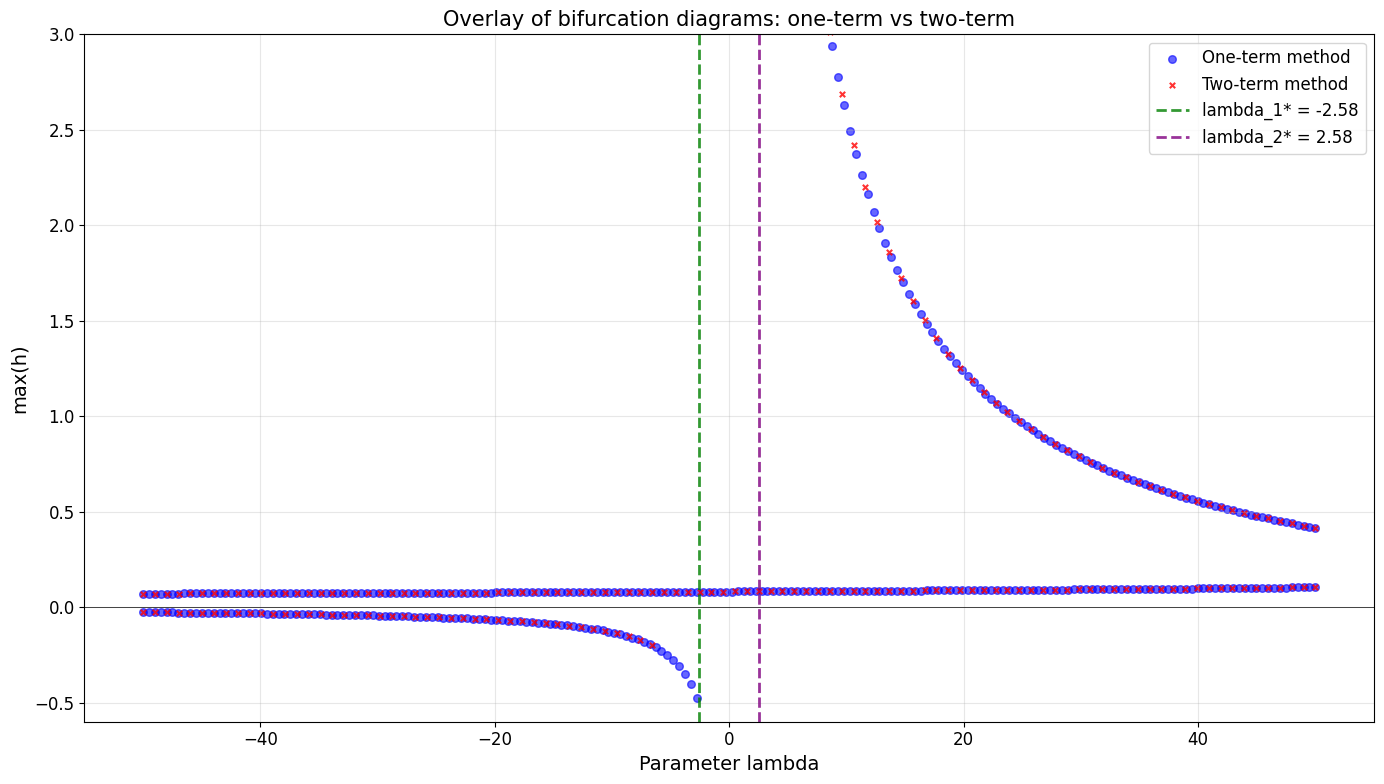

In [102]:
fig, ax = plt.subplots(figsize=(14, 8))

# One-term data (using existing scatter data)
ax.scatter(lam_scatter, h_max_scatter, c='blue', s=30, alpha=0.6,
           label='One-term method', marker='o')

# Two-term data (using corrected data)
ax.scatter(lam_2t, h1_max_2t, c='red', s=15, alpha=0.8,
           label='Two-term method', marker='x')

# Mark bifurcation points
ax.axvline(x=lambda_1_star, color='green', linewidth=2, linestyle='--',
           alpha=0.8, label=f'lambda_1* = {lambda_1_star:.2f}')
ax.axvline(x=lambda_2_star, color='purple', linewidth=2, linestyle='--',
           alpha=0.8, label=f'lambda_2* = {lambda_2_star:.2f}')

ax.axhline(y=0, color='k', linewidth=0.5)
ax.set_xlabel('Parameter lambda', fontsize=14)
ax.set_ylabel('max(h)', fontsize=14)
ax.set_title('Overlay of bifurcation diagrams: one-term vs two-term', fontsize=15)
ax.set_xlim(-55, 55)
ax.set_ylim(-0.6, 3)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 8. Contour plots of 2D solutions for both methods

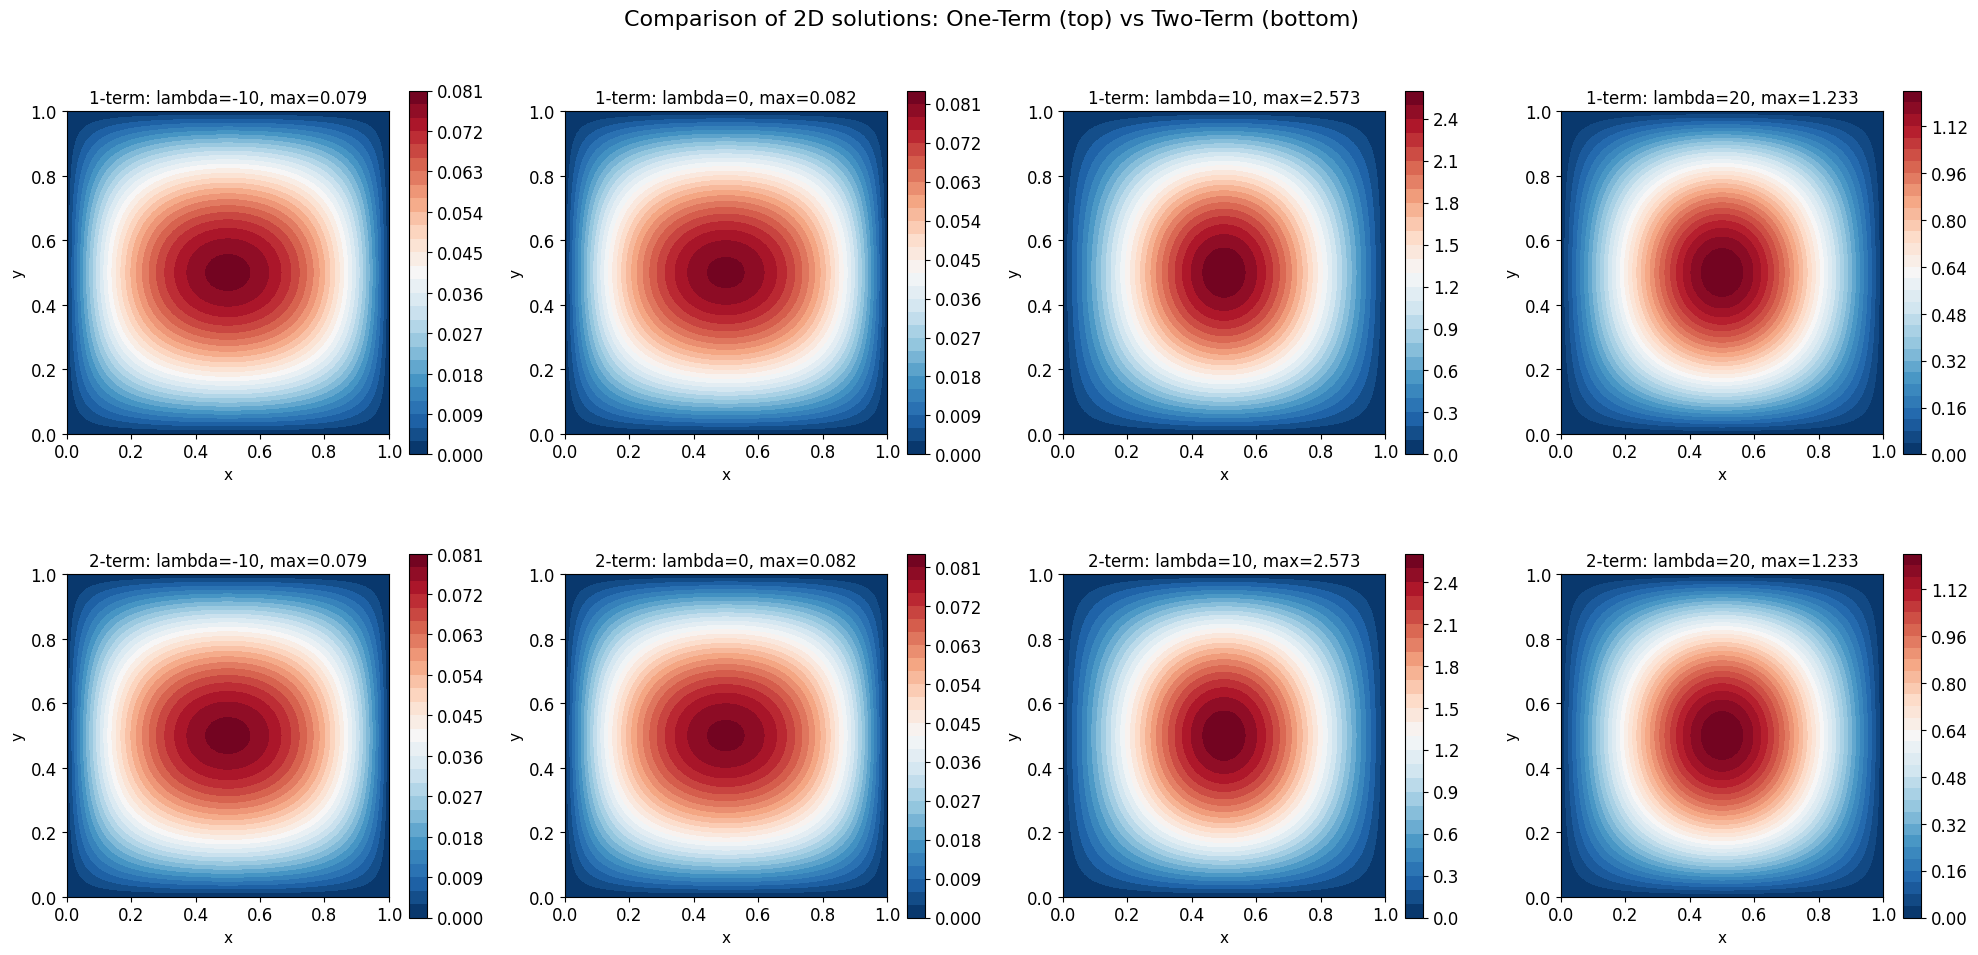

In [103]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Comparison of 2D solutions: One-Term (top) vs Two-Term (bottom)', fontsize=16, y=0.98)

test_lambdas_contour = [-10, 0, 10, 20]

for col, lam_val in enumerate(test_lambdas_contour):
    # One-term solution
    sols_1t = find_all_solutions_at_lambda(lam_val, N, dx, x_interior, num_trials=30)
    if len(sols_1t) > 0:
        sol_1t = max(sols_1t, key=lambda s: np.max(s))
        h_full_1t = np.concatenate([[0], sol_1t, [0]])
        
        x_1t = np.linspace(0, 1, N + 2)
        y_1t = np.linspace(0, 1, 101)
        X_1t, Y_1t = np.meshgrid(x_1t, y_1t)
        U_1t = np.outer(np.sin(np.pi * y_1t), h_full_1t)
        
        ax1 = axes[0, col]
        im1 = ax1.contourf(X_1t, Y_1t, U_1t, levels=30, cmap='RdBu_r')
        plt.colorbar(im1, ax=ax1, shrink=0.8)
        ax1.set_xlabel('x', fontsize=11)
        ax1.set_ylabel('y', fontsize=11)
        ax1.set_title(f'1-term: lambda={lam_val}, max={np.max(U_1t):.3f}', fontsize=12)
        ax1.set_aspect('equal')
    
    # Two-term solution
    sols_2t = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=25)
    if len(sols_2t) > 0:
        sol_2t = max(sols_2t, key=lambda s: np.max(s[:N_2term]))
        h1 = sol_2t[:N_2term]
        h2 = sol_2t[N_2term:]
        h1_full = np.concatenate([[0], h1, [0]])
        h2_full = np.concatenate([[0], h2, [0]])
        
        x_2t = np.linspace(0, 1, N_2term + 2)
        y_2t = np.linspace(0, 1, 101)
        X_2t, Y_2t = np.meshgrid(x_2t, y_2t)
        U_2t = np.outer(np.sin(np.pi * y_2t), h1_full) + np.outer(np.sin(2*np.pi * y_2t), h2_full)
        
        ax2 = axes[1, col]
        im2 = ax2.contourf(X_2t, Y_2t, U_2t, levels=30, cmap='RdBu_r')
        plt.colorbar(im2, ax=ax2, shrink=0.8)
        ax2.set_xlabel('x', fontsize=11)
        ax2.set_ylabel('y', fontsize=11)
        ax2.set_title(f'2-term: lambda={lam_val}, max={np.max(U_2t):.3f}', fontsize=12)
        ax2.set_aspect('equal')

plt.tight_layout()
plt.show()


### 9. Checking the influence of h2 using different metrics

**Important!** When using the point (1/2, 1/2), the contribution of h2 is not visible, since
sin(2*pi*0.5) = 0.

We therefore examine several different metrics:

* u(1/2, 1/2) — does NOT reveal h2
* u(1/2, 1/4) — reveals h2 (since sin(2*pi*0.25) = 1)
* L2 norm of u — integral norm
* Linf norm of u — maximum over the entire domain


In [104]:
def compute_2d_metrics(h1, h2, N_grid=50):
    """
    Compute various metrics for the 2D solution
    u(x,y) = h1(x)*sin(pi*y) + h2(x)*sin(2*pi*y)
    """
    # Grid for 2D computation
    x = np.linspace(0, 1, len(h1) + 2)  # include boundaries
    y = np.linspace(0, 1, N_grid + 2)
    dx_grid = x[1] - x[0]
    dy_grid = y[1] - y[0]
    
    # Full h with boundaries
    h1_full = np.concatenate([[0], h1, [0]])
    h2_full = np.concatenate([[0], h2, [0]])
    
    # 2D solution
    sin_pi_y = np.sin(np.pi * y)
    sin_2pi_y = np.sin(2 * np.pi * y)
    
    U = np.outer(sin_pi_y, h1_full) + np.outer(sin_2pi_y, h2_full)
    
    # Metrics
    # 1. u(1/2, 1/2) - center point (h2 not visible here)
    x_mid = len(h1_full) // 2
    y_mid = len(y) // 2
    u_center = U[y_mid, x_mid]
    
    # 2. u(1/2, 1/4) - point where sin(2*pi*y) = 1 (h2 is visible)
    y_quarter = len(y) // 4
    u_quarter = U[y_quarter, x_mid]
    
    # 3. L2 norm: sqrt(int int u^2 dx dy)
    L2_norm = np.sqrt(np.sum(U**2) * dx_grid * dy_grid)
    
    # 4. Linf norm: max |u|
    Linf_norm = np.max(np.abs(U))
    
    # 5. Contribution of the h2 term only
    U_h2_only = np.outer(sin_2pi_y, h2_full)
    h2_contribution = np.max(np.abs(U_h2_only))
    
    return {
        'u_center': u_center,            # u(1/2, 1/2)
        'u_quarter': u_quarter,          # u(1/2, 1/4)
        'L2_norm': L2_norm,              # ||u||_L2
        'Linf_norm': Linf_norm,          # ||u||_inf
        'h2_contribution': h2_contribution,
        'max_h1': np.max(h1),
        'max_h2': np.max(np.abs(h2))
    }


In [105]:
# Test with actual solutions
print(f"\nAt y = 0.5: sin(pi*0.5) = {np.sin(np.pi*0.5):.4f}, sin(2*pi*0.5) = {np.sin(2*np.pi*0.5):.4f}")
print(f"At y = 0.25: sin(pi*0.25) = {np.sin(np.pi*0.25):.4f}, sin(2*pi*0.25) = {np.sin(2*np.pi*0.25):.4f}")
print("\n" + "-"*80)

test_lambdas_metrics = [-10, 0, 10, 20]

for lam_val in test_lambdas_metrics:
    sols = find_all_solutions_2term(
        lam_val, N_2term, dx_2term, x_interior_2term, num_trials=25
    )
    
    if len(sols) == 0:
        print(f"\nlambda = {lam_val}: no solution found")
        continue
    
    # Take solution with largest h1
    sol = max(sols, key=lambda s: np.max(s[:N_2term]))
    h1_sol = sol[:N_2term]
    h2_sol = sol[N_2term:]
    
    metrics = compute_2d_metrics(h1_sol, h2_sol)
    
    print(f"\nlambda = {lam_val}:")
    print(f"  max(h1) = {metrics['max_h1']:.6f}")
    print(f"  max|h2| = {metrics['max_h2']:.2e}  <- KEY INDICATOR")
    print(f"  u(1/2, 1/2) = {metrics['u_center']:.6f}  (h2 not visible here)")
    print(f"  u(1/2, 1/4) = {metrics['u_quarter']:.6f}  (h2 visible here)")
    print(f"  ||u||_L2 = {metrics['L2_norm']:.6f}")
    print(f"  ||u||_inf = {metrics['Linf_norm']:.6f}")
    print(f"  h2 contribution: max|h2*sin(2*pi*y)| = {metrics['h2_contribution']:.2e}")

print("CONCLUSION: h2 == 0 FOR ALL SOLUTIONS, INDEPENDENT OF THE CHOSEN METRIC.")



At y = 0.5: sin(pi*0.5) = 1.0000, sin(2*pi*0.5) = 0.0000
At y = 0.25: sin(pi*0.25) = 0.7071, sin(2*pi*0.25) = 1.0000

--------------------------------------------------------------------------------

lambda = -10:
  max(h1) = 0.079202
  max|h2| = 1.40e-25  <- KEY INDICATOR
  u(1/2, 1/2) = 0.079164  (h2 not visible here)
  u(1/2, 1/4) = 0.056860  (h2 visible here)
  ||u||_L2 = 0.042028
  ||u||_inf = 0.079164
  h2 contribution: max|h2*sin(2*pi*y)| = 1.40e-25

lambda = 0:
  max(h1) = 0.081885
  max|h2| = 1.50e-15  <- KEY INDICATOR
  u(1/2, 1/2) = 0.081846  (h2 not visible here)
  u(1/2, 1/4) = 0.058786  (h2 visible here)
  ||u||_L2 = 0.043343
  ||u||_inf = 0.081846
  h2 contribution: max|h2*sin(2*pi*y)| = 1.50e-15

lambda = 10:
  max(h1) = 2.573277
  max|h2| = 2.54e-22  <- KEY INDICATOR
  u(1/2, 1/2) = 2.572057  (h2 not visible here)
  u(1/2, 1/4) = 1.847387  (h2 visible here)
  ||u||_L2 = 1.230494
  ||u||_inf = 2.572057
  h2 contribution: max|h2*sin(2*pi*y)| = 2.54e-22

lambda = 20:
  m

Total number of solution points found: 191


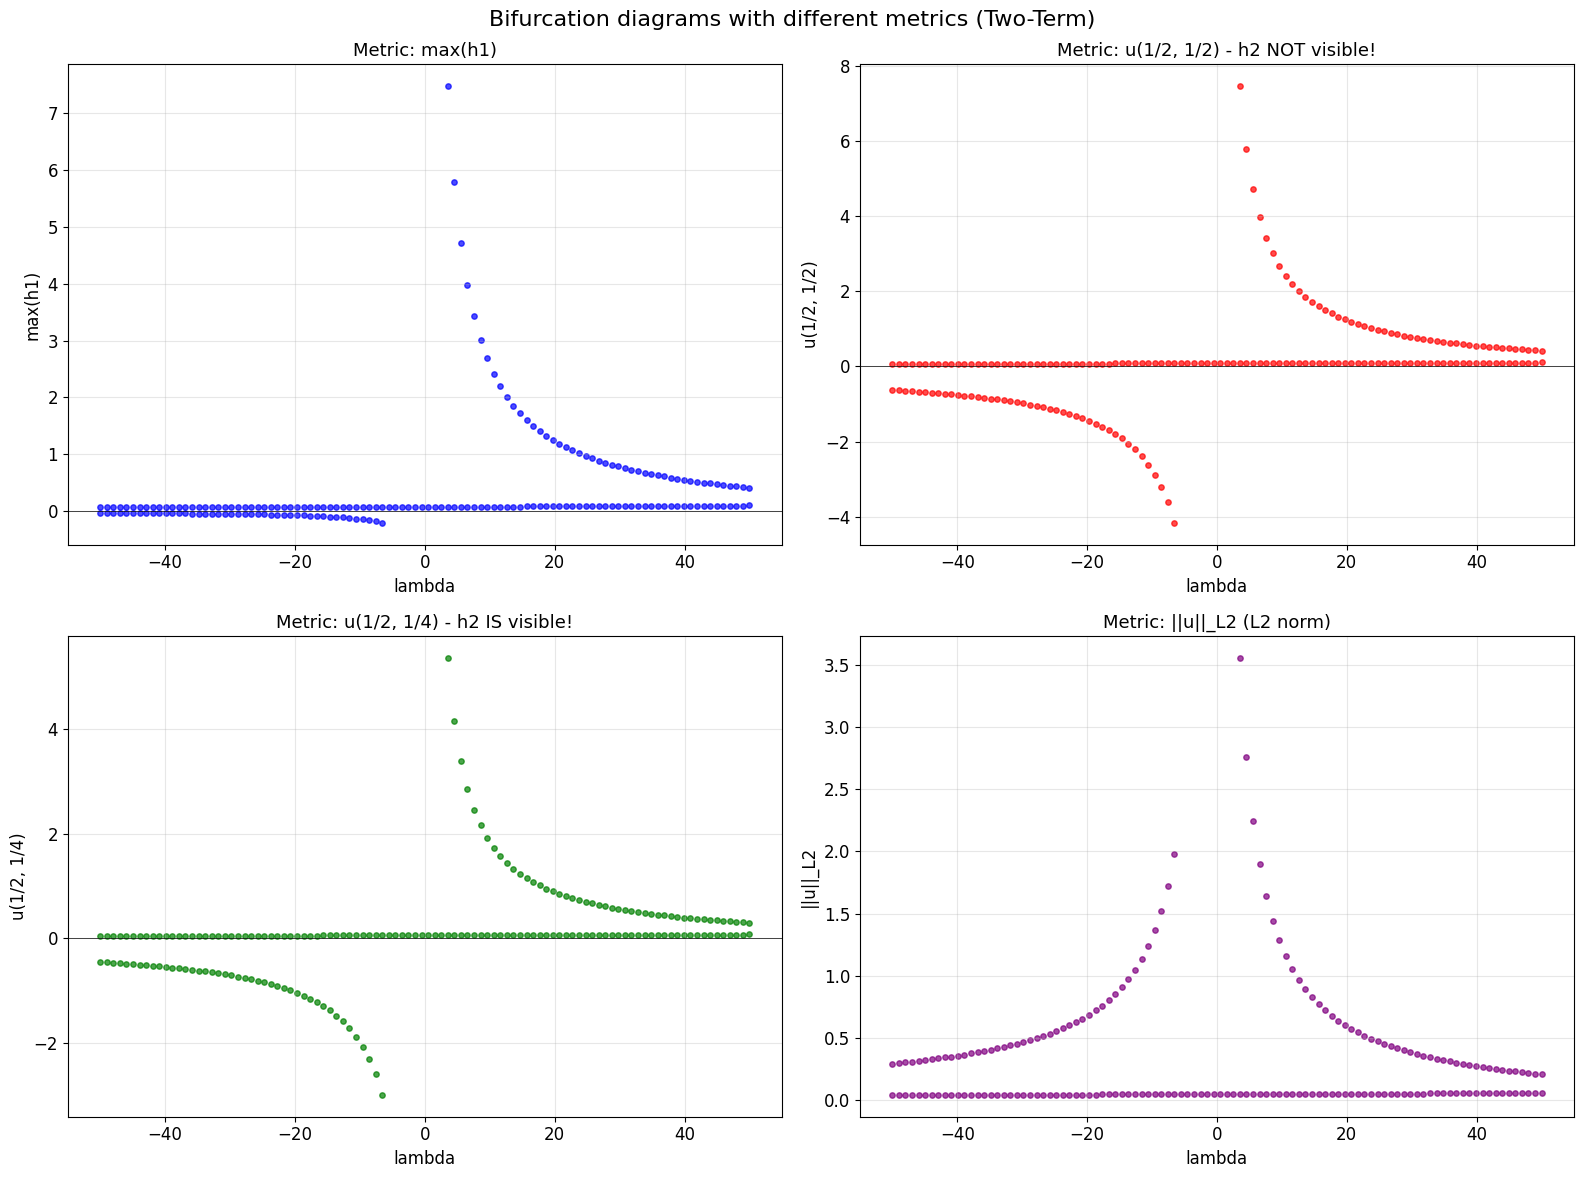

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Bifurcation diagrams with different metrics (Two-Term)', fontsize=16, y=0.98)

# Collect data with all metrics
lambda_range_metrics = np.linspace(-50, 50, 100)
metrics_data = {
    'lambda': [],
    'max_h1': [],
    'u_center': [],      # u(1/2, 1/2)
    'u_quarter': [],     # u(1/2, 1/4)
    'L2_norm': [],
    'Linf_norm': []
}

print("Collecting data for all metrics...")
for lam_val in lambda_range_metrics:
    sols = find_all_solutions_2term(lam_val, N_2term, dx_2term, x_interior_2term, num_trials=20)
    
    for sol in sols:
        h1_sol = sol[:N_2term]
        h2_sol = sol[N_2term:]
        m = compute_2d_metrics(h1_sol, h2_sol)
        
        metrics_data['lambda'].append(lam_val)
        metrics_data['max_h1'].append(m['max_h1'])
        metrics_data['u_center'].append(m['u_center'])
        metrics_data['u_quarter'].append(m['u_quarter'])
        metrics_data['L2_norm'].append(m['L2_norm'])
        metrics_data['Linf_norm'].append(m['Linf_norm'])

# Convert to arrays
for key in metrics_data:
    metrics_data[key] = np.array(metrics_data[key])

print(f"Total number of solution points found: {len(metrics_data['lambda'])}")

# Plot 1: max(h1) - the primary metric used
ax1 = axes[0, 0]
ax1.scatter(metrics_data['lambda'], metrics_data['max_h1'], c='blue', s=15, alpha=0.7)
ax1.set_xlabel('lambda', fontsize=12)
ax1.set_ylabel('max(h1)', fontsize=12)
ax1.set_title('Metric: max(h1)', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linewidth=0.5)

# Plot 2: u(1/2, 1/2) - center point (h2 NOT visible)
ax2 = axes[0, 1]
ax2.scatter(metrics_data['lambda'], metrics_data['u_center'], c='red', s=15, alpha=0.7)
ax2.set_xlabel('lambda', fontsize=12)
ax2.set_ylabel('u(1/2, 1/2)', fontsize=12)
ax2.set_title('Metric: u(1/2, 1/2) - h2 NOT visible!', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linewidth=0.5)

# Plot 3: u(1/2, 1/4) - quarter point (h2 IS visible)
ax3 = axes[1, 0]
ax3.scatter(metrics_data['lambda'], metrics_data['u_quarter'], c='green', s=15, alpha=0.7)
ax3.set_xlabel('lambda', fontsize=12)
ax3.set_ylabel('u(1/2, 1/4)', fontsize=12)
ax3.set_title('Metric: u(1/2, 1/4) - h2 IS visible!', fontsize=13)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linewidth=0.5)

# Plot 4: L2 norm
ax4 = axes[1, 1]
ax4.scatter(metrics_data['lambda'], metrics_data['L2_norm'], c='purple', s=15, alpha=0.7)
ax4.set_xlabel('lambda', fontsize=12)
ax4.set_ylabel('||u||_L2', fontsize=12)
ax4.set_title('Metric: ||u||_L2 (L2 norm)', fontsize=13)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
